**Supervised Learning Capstone 2: Incarceration Sentences in Washington DC**




This capstone project will consist of a study of features contained in a dataset provided by dcgis.dc.gov and employing them to create a model used in predicting incarceration terms.

The judicial system in Washington DC, like many cities in the United States, is facing many challenges. In DC, the Black population makes up 46% of the total population. However, the population of incarcerated citizens is drastically different with almost 90% of the incarcerated population being Black. 

Statistics like these tend to raise many questions regarding racial equality in the justice system. From the arrests to the court sentencing process, the system is under an equality microscope.

This analysis will focus on the sentencing step of the incarceration process. A dataset of over 13,000 arrests that resulted in incarceration terms of at least 1 month will be analyzed to create a model that predicts incarceration sentences. As a secondary objective, the analysis will also determine if race has any significance in predicting a jail sentence.

**Step 1:** Import dataset

In [345]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
plt.style.use('seaborn')

# Bring in CSV to DataFrame - ORIGINAL URL: https://opendata.dc.gov/datasets/9fa34e198ad240358c7c36bc063d2058?orderBy=OFFENSE_SEVERITY_GROUP&page=2
prison_df = pd.read_csv('https://raw.githubusercontent.com/fdortega/pythonobjects/master/Felony_Sentences.csv')

**Data Description**

The data used in this study was obtained from [Open Data DC](https://opendata.dc.gov/datasets/9fa34e198ad240358c7c36bc063d2058?orderBy=OFFENSE_SEVERITY_GROUP&page=2). 


The time frame of arrests includes arrests done between 2010 through 2018. The original dataset includes 23,332 instances that resulted in sentences that ranged between probation and life in prison. There are 22 columns that include the offender age, gender, offense, and prison sentence (Remaining columns - see below). The focus of the study will be only on the instances that resulted in prison time of one month or greater.

In [346]:
# Preview and inspect data
prison_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23332 entries, 0 to 23331
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OBJECTID                   23332 non-null  int64  
 1   RID                        23332 non-null  int64  
 2   GENERIC_CASE_ID            23332 non-null  int64  
 3   GENERIC_OFFENDER_ID        23332 non-null  int64  
 4   CHARGE_NUMBER              23332 non-null  int64  
 5   SENTENCE_YEAR              23332 non-null  int64  
 6   RACE                       23332 non-null  object 
 7   GENDER                     23076 non-null  object 
 8   AGE_GROUP                  23225 non-null  object 
 9   OFFENSE                    23332 non-null  object 
 10  OFFENSE_TYPE               23332 non-null  object 
 11  HOMICIDE_TYPE              728 non-null    object 
 12  OFFENSE_SEVERITY_GROUP     23331 non-null  object 
 13  SENTENCE_TYPE              23332 non-null  obj

In [347]:
prison_df.head()

,OBJECTID,RID,GENERIC_CASE_ID,GENERIC_OFFENDER_ID,CHARGE_NUMBER,SENTENCE_YEAR,RACE,GENDER,AGE_GROUP,OFFENSE,OFFENSE_TYPE,HOMICIDE_TYPE,OFFENSE_SEVERITY_GROUP,SENTENCE_TYPE,SENTENCE_IMPOSED_MONTHS,SENTENCE_SUSPENDED_MONTHS,SENTENCE_TO_SERVE_MONTHS,SENTENCE_PROBATION_MONTHS,VVCA_AMT,FINE_AMT,RESTITUTION_AMT,FINE_SUSPENDED_AMT
0,1,1,3574668,3485785,1,2018,Black,M,15-17,1ST DEG MURDER W/ARMED,Homicide,Murder I,M1,Indeterminate/Incarceration,NaN,NaN,NaN,NaN,100,0.0,0.0,0.0
1,2,2,3806508,7427096,9,2018,Black,M,15-17,Conspiracy,Other,NaN,M9,Indeterminate,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0
2,3,3,3806508,7427096,12,2018,Black,M,15-17,Murder I,Homicide,Murder I,M1,Life,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0
3,4,4,3806508,7427096,13,2018,Black,M,15-17,1ST DEG MURDER W/ARMED,Homicide,Murder I,M1,Life,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0
4,5,5,3806508,7427096,15,2018,Black,M,15-17,Poss Firearm During Crime of Violence or Dange...,Weapon,NaN,M5,Indeterminate,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0


In [348]:
# 22 total columns and over 20k instances with a good blend of
# categorical and continuous data
prison_df.dtypes.value_counts()

object     8
int64      7
float64    7
dtype: int64

In [349]:
# Convert to column header fonts to all lower case
prison_df.columns = prison_df.columns.str.lower()

In [350]:
# Descripitve statistics
prison_df.describe()

,objectid,rid,generic_case_id,generic_offender_id,charge_number,sentence_year,sentence_imposed_months,sentence_suspended_months,sentence_to_serve_months,sentence_probation_months,vvca_amt,fine_amt,restitution_amt,fine_suspended_amt
count,23332.000000,23332.000000,2.333200e+04,2.333200e+04,23332.000000,23332.000000,23095.000000,23095.000000,23095.000000,23095.000000,23332.000000,12348.000000,12390.000000,12290.000000
mean,11666.500000,11666.500000,5.066496e+06,5.036338e+06,2.788574,2013.502743,36.632128,6.046374,30.657545,7.859840,130.951654,3.529773,366.270579,1.448332
std,6735.512576,6735.512576,2.868902e+06,2.889586e+06,4.632238,2.631178,55.461958,11.377882,56.962942,12.118146,215.135736,99.422076,5092.855890,78.648265
min,1.000000,1.000000,2.062000e+03,1.946000e+03,1.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5833.750000,5833.750000,2.568996e+06,2.527690e+06,1.000000,2011.000000,12.000000,0.000000,1.000000,0.000000,100.000000,0.000000,0.000000,0.000000
50%,11666.500000,11666.500000,5.088490e+06,5.065712e+06,1.000000,2013.000000,20.000000,0.000000,14.000000,0.000000,100.000000,0.000000,0.000000,0.000000
75%,17499.250000,17499.250000,7.564773e+06,7.557304e+06,2.000000,2016.000000,36.000000,12.000000,36.000000,12.000000,100.000000,0.000000,0.000000,0.000000
max,23332.000000,23332.000000,9.998825e+06,9.999421e+06,104.000000,2018.000000,840.000000,613.000000,840.000000,216.000000,10000.000000,5000.000000,228036.000000,5000.000000


In [351]:
# There are several types of sentence types, only concerned with incarceration(not-probation).
prison_df.sentence_type.value_counts()

Incarceration                  13542
Probation                       4258
Short Split                     4228
Long Split                      1067
Indeterminate                    152
Indeterminate/Incarceration       48
Life                              37
Name: sentence_type, dtype: int64

In [352]:
# Drop short split, long split, and all indeterminates. Only keep incarceration
prison_df = prison_df[prison_df['sentence_type'].str.contains('Incarceration') | prison_df['sentence_type'].str.contains('Life')]
prison_df = prison_df[prison_df['sentence_type'].str.contains('Indeterminate') == False]

# View remaining sentence type counts
print(prison_df.sentence_type.value_counts(),'\n')

prison_df.sentence_type.shape

Incarceration    13542
Life                37
Name: sentence_type, dtype: int64 



(13579,)

Dataframe now includes the incarceration target rows of interest.

**Data Cleaning** - Missing Values


In [353]:
# Data is now at 13579 instances
# Address Missing Values
prison_df.isnull().sum() * 100 / prison_df.isnull().count()

objectid                      0.000000
rid                           0.000000
generic_case_id               0.000000
generic_offender_id           0.000000
charge_number                 0.000000
sentence_year                 0.000000
race                          0.000000
gender                        1.053097
age_group                     0.243022
offense                       0.000000
offense_type                  0.000000
homicide_type                95.154282
offense_severity_group        0.000000
sentence_type                 0.000000
sentence_imposed_months       0.272480
sentence_suspended_months     0.272480
sentence_to_serve_months      0.272480
sentence_probation_months     0.272480
vvca_amt                      0.000000
fine_amt                     38.110317
restitution_amt              37.756830
fine_suspended_amt           38.213418
dtype: float64

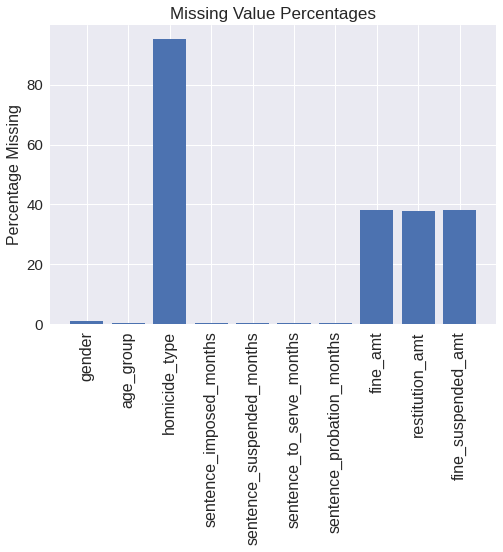

In [354]:
# Create visualization for presentation purpose
hhh = prison_df.isnull().sum() * 100 / prison_df.isnull().count()
hhh = hhh[hhh[:] > 0]
plt.bar(hhh.index, hhh[:])
plt.xticks(rotation = 90, size = 16)
plt.yticks(size = 15)
plt.title('Missing Value Percentages', size = 17)
plt.ylabel('Percentage Missing', size = 16)
plt.show()

In [355]:
# Gender missing values (will assign a 3rd class to avoid dropping data)
prison_df.gender.fillna(value = 'not_recorded', inplace = True)

# homicide_type (missing values are due to the charge not being homicide related)
prison_df.homicide_type.fillna(value = 'not_homicide', inplace = True)

# The 'sentence_suspended_months' column has a value of zero throughout column
# The 'sentence_probation_months' is applicable to a sentence type not of interest
# The 'sentence_imposed_months' is an exact duplicate column of the target column
# The above three columns will be dropped
prison_df.drop(columns = ['sentence_suspended_months', 'sentence_probation_months', 'sentence_imposed_months' ], inplace = True)

# Fines and fees columns have missing values have 37% of values missing
# These values will be replaced by zeros
prison_df.fine_amt.fillna(value = 0, inplace = True)
prison_df.restitution_amt.fillna(value = 0, inplace = True)
prison_df.fine_suspended_amt.fillna(value = 0, inplace = True)

In [356]:
# Few missing values remain
prison_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13579 entries, 2 to 23331
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   objectid                  13579 non-null  int64  
 1   rid                       13579 non-null  int64  
 2   generic_case_id           13579 non-null  int64  
 3   generic_offender_id       13579 non-null  int64  
 4   charge_number             13579 non-null  int64  
 5   sentence_year             13579 non-null  int64  
 6   race                      13579 non-null  object 
 7   gender                    13579 non-null  object 
 8   age_group                 13546 non-null  object 
 9   offense                   13579 non-null  object 
 10  offense_type              13579 non-null  object 
 11  homicide_type             13579 non-null  object 
 12  offense_severity_group    13579 non-null  object 
 13  sentence_type             13579 non-null  object 
 14  senten

In [357]:
# Remaining missing values are in the age_group column and target column - get total percentage missing
print('Age Group Missing Value Percentage:')
print((prison_df.age_group.shape[0] - prison_df.age_group.value_counts().sum()) * 100 / prison_df.age_group.shape[0])
print('Sentence to Serve Months Missing Value Percentage:')
print((prison_df.sentence_to_serve_months.shape[0] - prison_df.sentence_to_serve_months.value_counts().sum()) * 100 / prison_df.sentence_to_serve_months.shape[0])

# Very small percentage of missing values -> Drop missing age and empty sentence term values
# Missing values in target correspond to Life sentence type, will drop the 37 missing rows
prison_df.dropna(inplace = True)

Age Group Missing Value Percentage:
0.24302231386700052
Sentence to Serve Months Missing Value Percentage:
0.2724795640326976


In [358]:
# Verify data has no more missing values
prison_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13509 entries, 15 to 23331
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   objectid                  13509 non-null  int64  
 1   rid                       13509 non-null  int64  
 2   generic_case_id           13509 non-null  int64  
 3   generic_offender_id       13509 non-null  int64  
 4   charge_number             13509 non-null  int64  
 5   sentence_year             13509 non-null  int64  
 6   race                      13509 non-null  object 
 7   gender                    13509 non-null  object 
 8   age_group                 13509 non-null  object 
 9   offense                   13509 non-null  object 
 10  offense_type              13509 non-null  object 
 11  homicide_type             13509 non-null  object 
 12  offense_severity_group    13509 non-null  object 
 13  sentence_type             13509 non-null  object 
 14  sente

**Cleaning Data** - Outliers


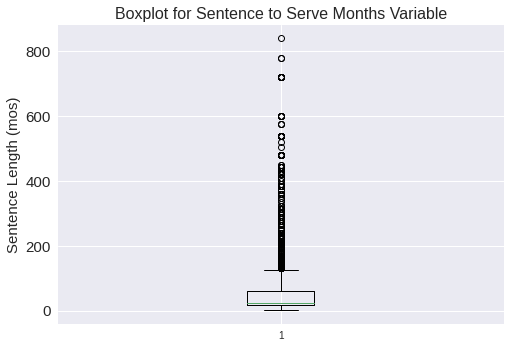

In [359]:
# Outliers and Distribution of Target Value
plt.boxplot(x = prison_df.sentence_to_serve_months)
plt.yticks(size = 15)
plt.title('Boxplot for Sentence to Serve Months Variable', size = 16)
plt.ylabel('Sentence Length (mos)', size = 15)
plt.show()

Inspect the distribution of the target variable

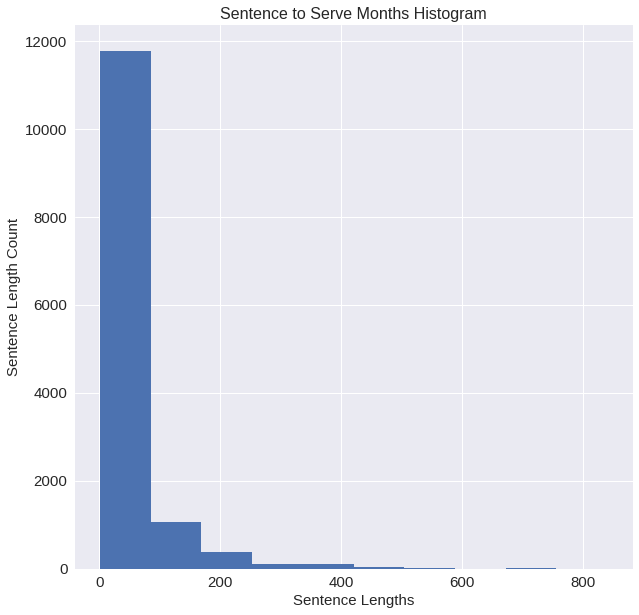

In [360]:
# Target distribution
plt.figure(figsize = (10, 10))
plt.hist(prison_df.sentence_to_serve_months)
plt.title('Sentence to Serve Months Histogram', size = 16)
plt.ylabel('Sentence Length Count', size = 15)
plt.xlabel('Sentence Lengths', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

Heavily right skewed distribution

Apply boxcox transformation to remedy skewness

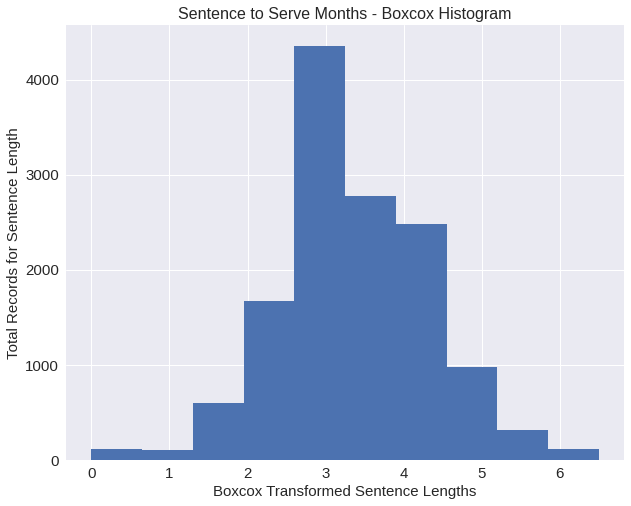

Jarque-Bera test statistics is 48911.84056492452 and p value is 0.0
Normality test statistics is 5673.072379835765 and p value is 0.0


In [361]:
# Transform the sentence to serve months with boxcox and check for normality
boxcox_sentence,_ = stats.boxcox(prison_df.sentence_to_serve_months)

# Add boxcox sentence feature to dataframe
prison_df['boxcox_sentence'] = boxcox_sentence

# Plot histogram
plt.figure(figsize = (10, 8))
plt.hist(prison_df.boxcox_sentence)
plt.title('Sentence to Serve Months - Boxcox Histogram', size = 16)
plt.ylabel('Total Records for Sentence Length', size = 15)
plt.xlabel('Boxcox Transformed Sentence Lengths', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

# Imports
from scipy.stats import jarque_bera
from scipy.stats import normaltest

# Adding a 1 to all values to avoid divide by zero errors when testing for normality
boxcox_for_norm_test = boxcox_sentence + 1

# Assign a variable to each test performed for ‘subscribers’
jb_stats = jarque_bera(np.log(boxcox_for_norm_test))
norm_stats = normaltest(np.log(boxcox_for_norm_test))

# Print results of tests
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

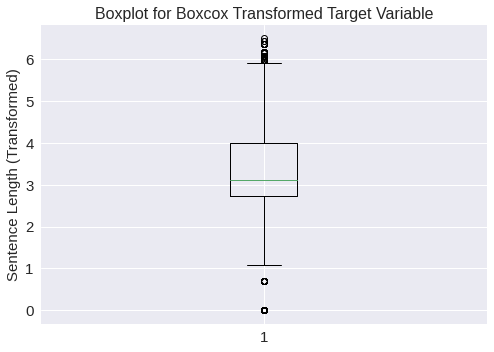

In [362]:
# Outliers and Distribution of Target Value with Boxcox transformation
plt.boxplot(x = prison_df.boxcox_sentence)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.title('Boxplot for Boxcox Transformed Target Variable', size = 16)
plt.ylabel('Sentence Length (Transformed)', size = 15)
plt.show()

Outliers left in data

**Data Exploration**

In [363]:
# preview data
prison_df.head()

,objectid,rid,generic_case_id,generic_offender_id,charge_number,sentence_year,race,gender,age_group,offense,offense_type,homicide_type,offense_severity_group,sentence_type,sentence_to_serve_months,vvca_amt,fine_amt,restitution_amt,fine_suspended_amt,boxcox_sentence
15,16,16,8567971,8258401,4,2018,Black,M,22-30,POS. F/A DURING VIO/DAG OFF,Weapon,not_homicide,M5,Incarceration,1.0,100,0.0,0.0,0.0,0.0
16,17,17,8567971,8258401,7,2018,Black,M,22-30,POS. F/A DURING VIO/DAG OFF,Weapon,not_homicide,M5,Incarceration,1.0,100,0.0,0.0,0.0,0.0
17,18,18,8567971,8258401,10,2018,Black,M,22-30,POS. F/A DURING VIO/DAG OFF,Weapon,not_homicide,M5,Incarceration,1.0,100,0.0,0.0,0.0,0.0
18,19,19,8567971,8258401,11,2018,Black,M,22-30,CARRY PISTOL W/O LIC-OUTSIDE H0ME/BUSINESS,Weapon,not_homicide,M8,Incarceration,1.0,100,0.0,0.0,0.0,0.0
19,20,20,8567971,8258401,12,2018,Black,M,22-30,ADW GUN,Violent,not_homicide,M6,Incarceration,1.0,100,0.0,0.0,0.0,0.0


Examples of crimes in each severity group

M1 = Felony First Degree Murder

M2 = Second Degree Murder and First Degree Sexual Abuse

M3 = Burglary One, Voluntary Manslaughter, Kidnapping, First Degree Child Sex Abuse

M4 = Aggravated Assault Knowingly, Voluntary Manslaughter, Soliciting Murder

M5 = Poss Firearm During Crime of Violence, Obstructing Justice, Robbery, Kidnapping, Involuntary Manslaughter

M6 = Assault With A Dangerous Weapon, Robbery, Arson, 
M7 = 
M8 = 


**Data Exploration** - Continuous Variables

In [364]:
prison_df.dtypes.value_counts()

object     8
int64      7
float64    5
dtype: int64

Continuous variables below will not be considered.

* objectid == rid, will eliminate both since not related to data (just an index for the table)

*  generic_case_id is an anonymized numer to represent the real case numbers

In [365]:
# Will eliminate continuous variables as listed above.
prison_df.drop(columns = ['objectid', 'rid', 'generic_case_id'], inplace = True)

* generic_offender_id and charge_number - may be useful to create a new column for offenders with multiple crimes

In [366]:
# Inspect both generic_offender_id and charge_number columns to see if they both  
# represent the same information regarding the number of individuals that are repeated
print(prison_df.generic_offender_id.value_counts().sum() == prison_df.charge_number.value_counts().sum())

# Keep only one of the columns (dropping charge_number)
prison_df.drop(columns = ['charge_number'], inplace = True)

True


Changing sentence_year into a categorical field instead of continuous

In [367]:
# Convert sentence_year to an object
prison_df['sentence_year'] = prison_df['sentence_year'].astype(object)

Continuous variable distributions and correlations

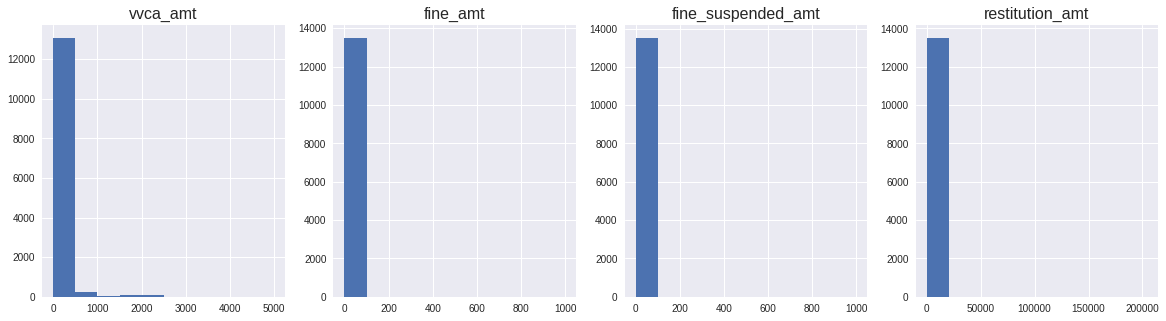

In [368]:
# Distribution of continuous variables
plt.figure(figsize = (20,5))

plt.subplot(1,4,1)
plt.hist(prison_df.vvca_amt)
plt.title('vvca_amt', size = 16)

plt.subplot(1,4,2)
plt.hist(prison_df.fine_amt)
plt.title('fine_amt', size = 16)

plt.subplot(1,4,3)
plt.hist(prison_df.fine_suspended_amt)
plt.title('fine_suspended_amt', size = 16)

plt.subplot(1,4,4)
plt.hist(prison_df.restitution_amt)
plt.title('restitution_amt', size = 16)

plt.show()

Heavily right skewed continuous variables

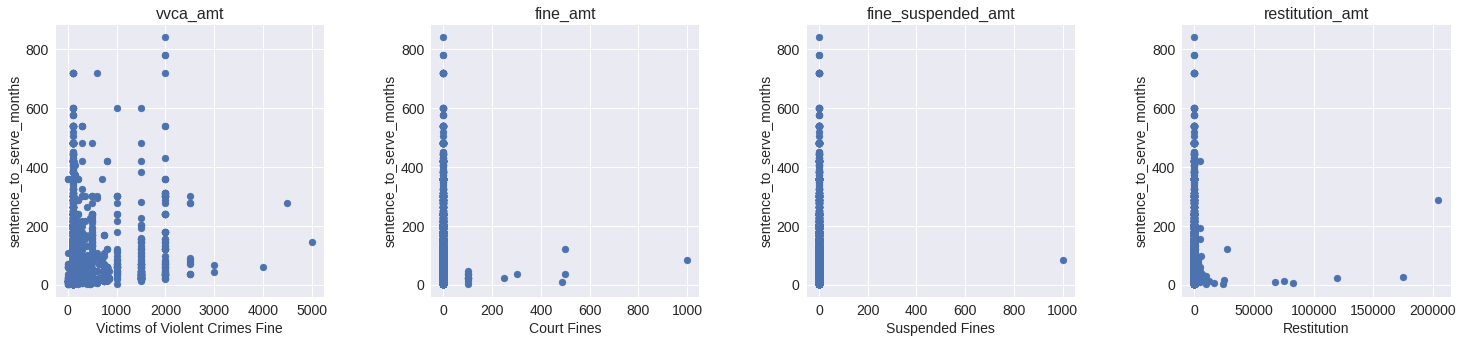

In [369]:
# Scatter plot of all continuous
plt.figure(figsize = (25,5))

plt.subplot(1,4,1)
plt.scatter(prison_df.vvca_amt, prison_df.sentence_to_serve_months)
plt.title('vvca_amt', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Victims of Violent Crimes Fine', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplot(1,4,2)
plt.scatter(prison_df.fine_amt, prison_df.sentence_to_serve_months)
plt.title('fine_amt', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Court Fines', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplot(1,4,3)
plt.scatter(prison_df.fine_suspended_amt, prison_df.sentence_to_serve_months)
plt.title('fine_suspended_amt', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Suspended Fines', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplot(1,4,4)
plt.scatter(prison_df.restitution_amt, prison_df.sentence_to_serve_months)
plt.title('restitution_amt', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Restitution', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplots_adjust(wspace = .4)
plt.show()

In [370]:
# Sort from highest correlated to least
correlations = prison_df.corr()['boxcox_sentence'].sort_values(ascending = False)
print('Most positive correlations:\n', correlations)

Most positive correlations:
 boxcox_sentence             1.000000
sentence_to_serve_months    0.774407
vvca_amt                    0.142227
fine_suspended_amt          0.009021
fine_amt                    0.005207
restitution_amt             0.000193
generic_offender_id        -0.004987
Name: boxcox_sentence, dtype: float64


Minor correlation exists only in vvca_amt variable. Will include variables in initial models

In [371]:
# Transforming each of the fine columns as well, may remove if it does not improve model performance
# add 1 to each value for boxcox transformarion
prison_df['vvca_amt'] = prison_df['vvca_amt'] + 1
prison_df['fine_amt'] = prison_df['fine_amt'] + 1
prison_df['restitution_amt'] = prison_df['restitution_amt'] + 1
prison_df['fine_suspended_amt'] = prison_df['fine_suspended_amt'] + 1

boxcox_vvca,_ = stats.boxcox(prison_df.vvca_amt)
boxcox_fine,_ = stats.boxcox(prison_df.fine_amt)
boxcox_restitution,_ = stats.boxcox(prison_df.restitution_amt)
boxcox_fine_susp,_ = stats.boxcox(prison_df.fine_suspended_amt)

prison_df['boxcox_vvca'] = boxcox_vvca
prison_df['boxcox_fine'] = boxcox_fine
prison_df['boxcox_restitution'] = boxcox_restitution
prison_df['boxcox_fine_susp'] = boxcox_fine_susp

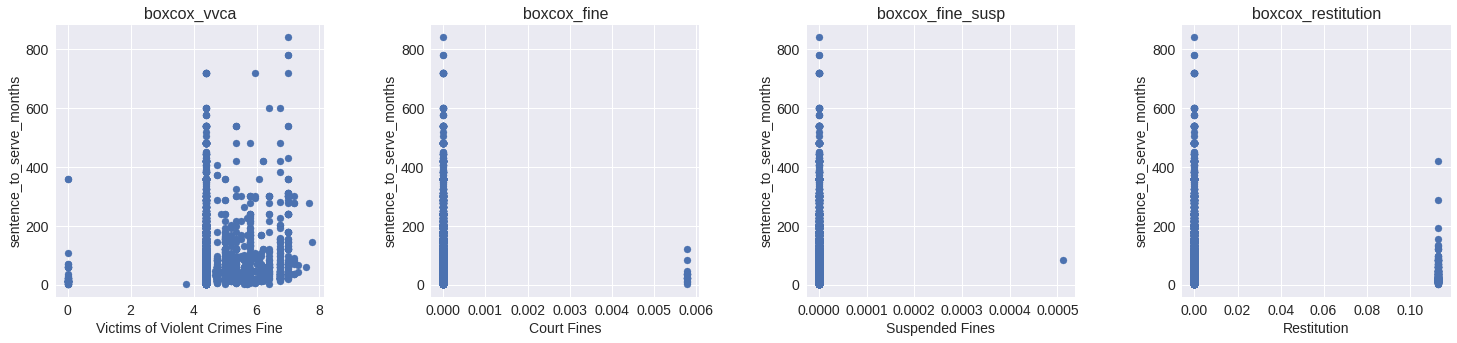

In [372]:
# Scatter plot of all continuous variables after transform
plt.figure(figsize = (25,5))

plt.subplot(1,4,1)
plt.scatter(prison_df.boxcox_vvca, prison_df.sentence_to_serve_months)
plt.title('boxcox_vvca', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Victims of Violent Crimes Fine', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplot(1,4,2)
plt.scatter(prison_df.boxcox_fine, prison_df.sentence_to_serve_months)
plt.title('boxcox_fine', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Court Fines', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplot(1,4,3)
plt.scatter(prison_df.boxcox_fine_susp, prison_df.sentence_to_serve_months)
plt.title('boxcox_fine_susp', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Suspended Fines', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplot(1,4,4)
plt.scatter(prison_df.boxcox_restitution, prison_df.sentence_to_serve_months)
plt.title('boxcox_restitution', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Restitution', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplots_adjust(wspace = .4)
plt.show()

As expected the fines are very weakly correlated to one another and to the target. Will leave them in to see if they improve predictions in lower term sentences.

**Data Exploration** - Categorical Variables

In [373]:
# Get a count of categorical variables in each categorical feature
prison_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0).sort_values(ascending = False)

offense                   195
offense_severity_group     13
sentence_year               9
age_group                   8
offense_type                7
homicide_type               5
race                        5
gender                      3
sentence_type               1
dtype: int64

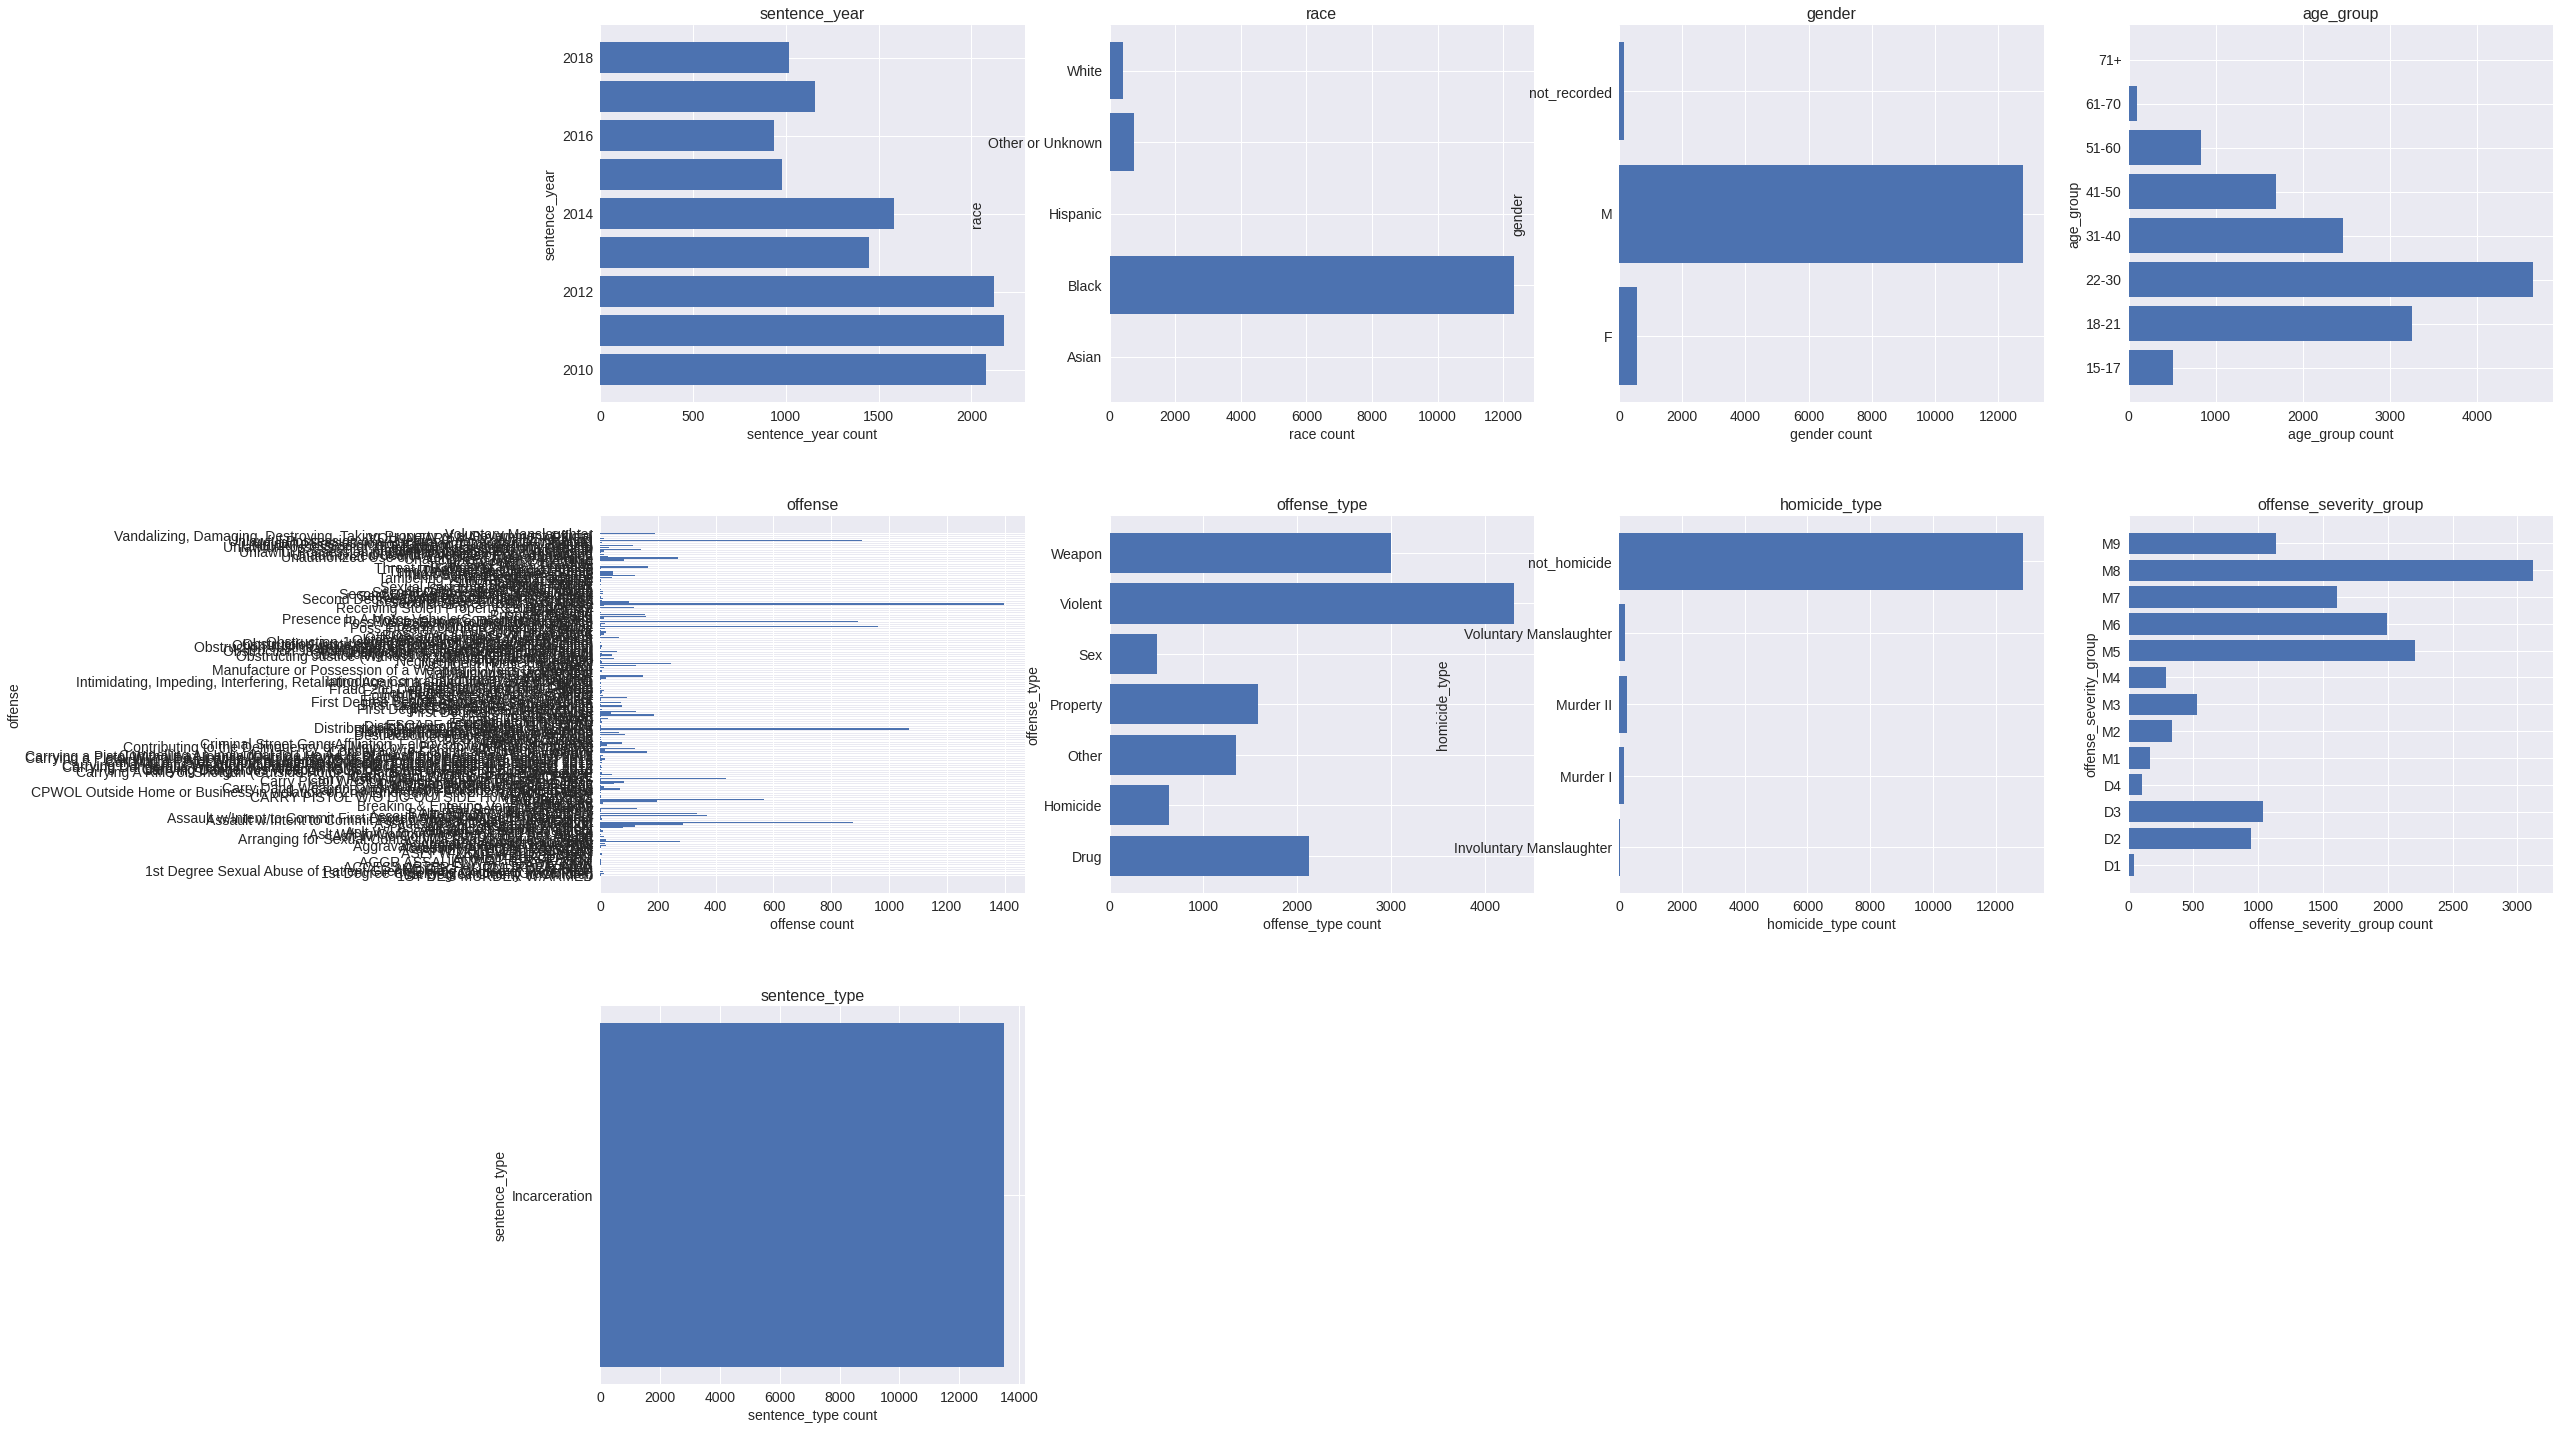

In [374]:
# Categorical Data Exploration

# create a list of all category columns
categoricals = list(prison_df.select_dtypes(include = 'object').columns)

# Loop through category list and plot the total instances of each category variable
plt.figure(figsize = (35, 25))
i=1
for categs in categoricals:
  plt.subplot(3,4,i)
  plt.barh(prison_df.groupby(categs)[categs].count().index,
           prison_df.groupby(categs)[categs].count())
  plt.title(categs, size = 16)
  plt.xticks(size = 14)
  plt.yticks(size = 14)
  plt.xlabel(categs + ' count', size = 14)
  plt.ylabel(categs, size = 14)
  i = i + 1
plt.subplots_adjust(wspace = .2, hspace = .3)
plt.show()

Possible reduction of dimensions in the following categories:
* Race, gender, offense, and homicide type

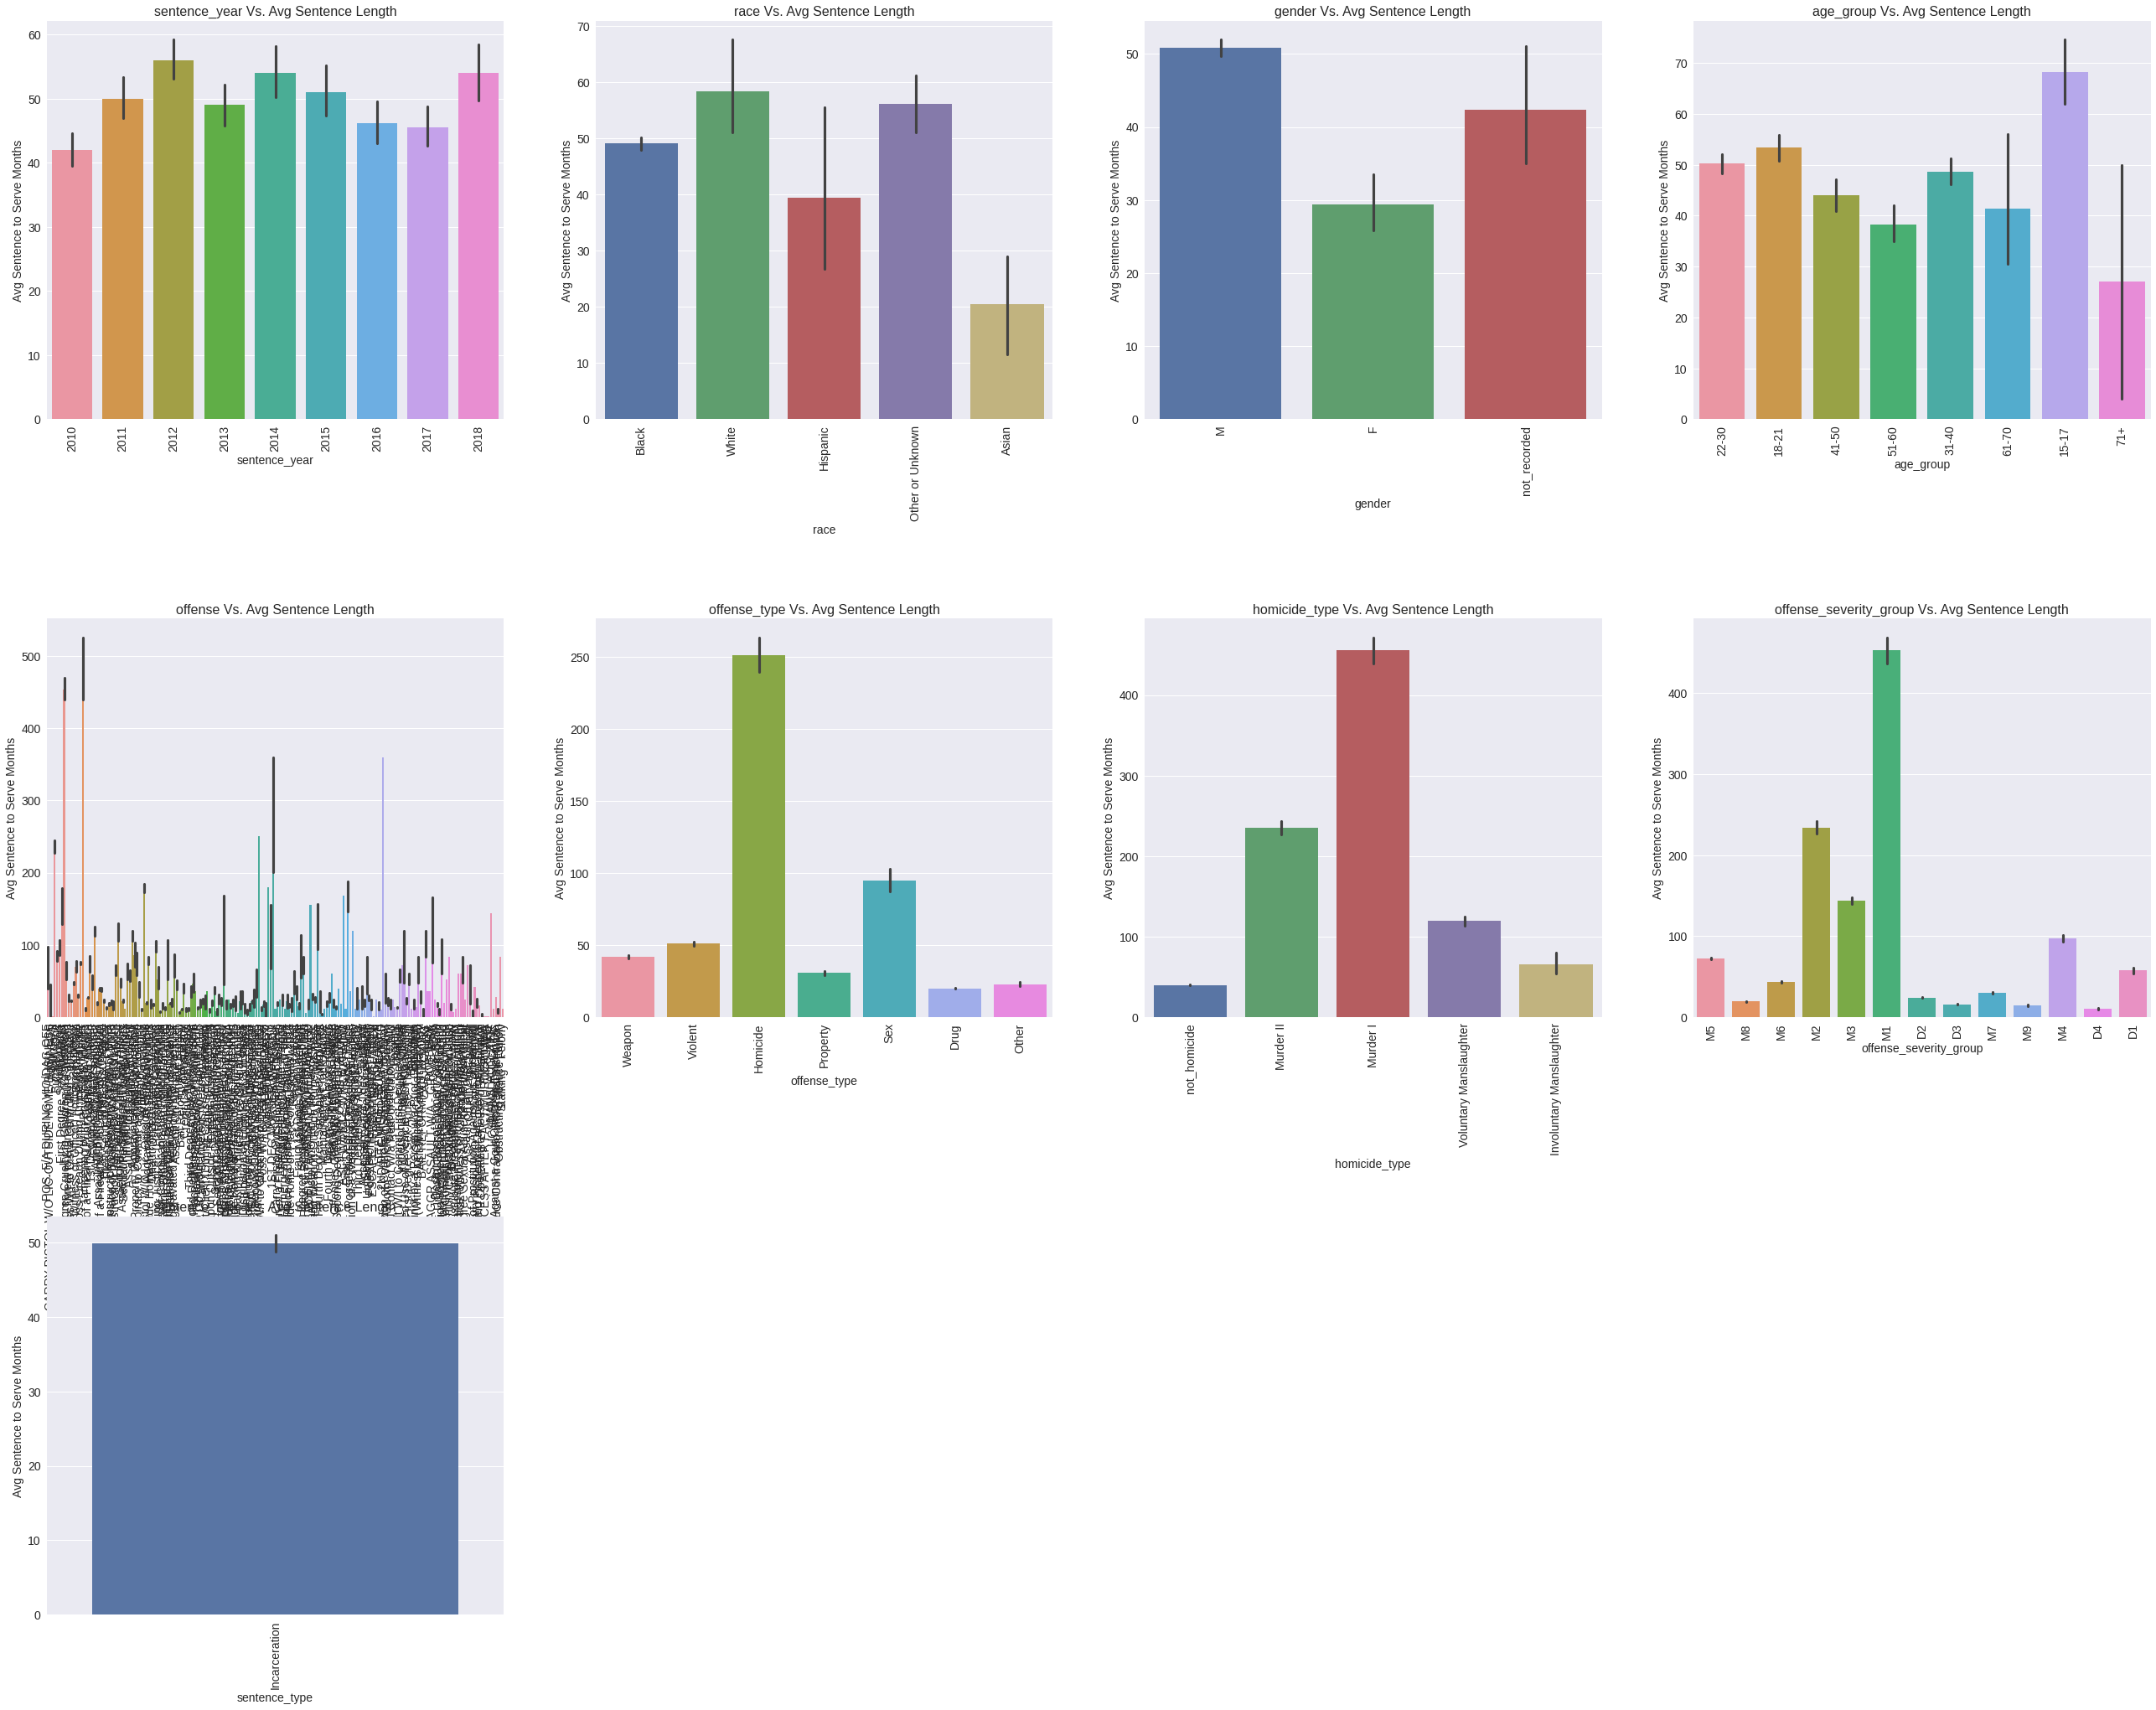

In [375]:
# Bivariate analysis, categoricals vs target mean

# Loop through the category columns and plot each category variable and
# the corresponding average sentence in months
plt.figure(figsize = (45, 35))
i=1
for categs in categoricals:
  plt.subplot(3,4,i)
  sns.barplot(prison_df[categs], prison_df.sentence_to_serve_months)
  plt.title(categs + ' Vs. Avg Sentence Length', size = 16)
  plt.xticks(rotation = 90, size = 14)
  plt.yticks(size = 14)
  plt.xlabel(categs, size = 14)
  plt.ylabel('Avg Sentence to Serve Months', size = 14)
  i = i + 1
plt.subplots_adjust(wspace = .2, hspace = .5)
plt.show()

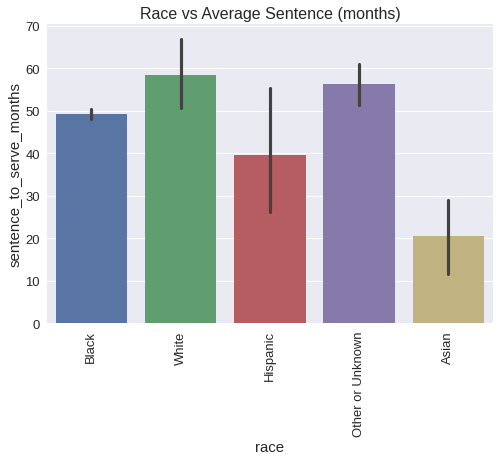

In [376]:
  # Plot of individual bivariate from above group
  sns.barplot(prison_df.race, prison_df.sentence_to_serve_months)
  plt.title('Race vs Average Sentence (months)', size = 16)
  plt.xticks(rotation = 90, size = 13)
  plt.yticks(size = 13)
  plt.xlabel('race', size = 15)
  plt.ylabel('sentence_to_serve_months', size = 15)
  plt.show()

Observation of sentence length as it relates to race and offense severity group

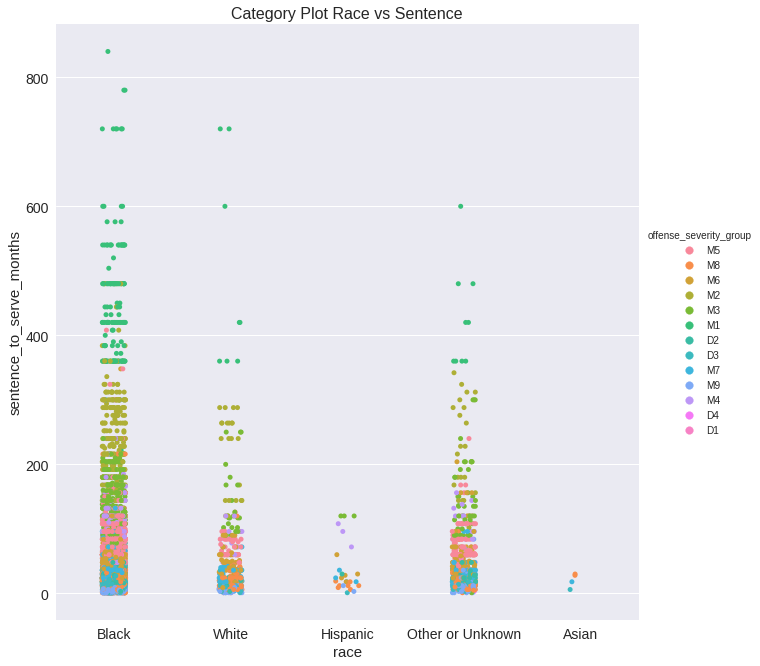

In [377]:
sns.catplot(x = 'race', y = 'sentence_to_serve_months', data = prison_df, hue = 'offense_severity_group', height = 9, aspect = 1)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel('race', size = 15)
plt.ylabel('sentence_to_serve_months', size = 15)
plt.title('Category Plot Race vs Sentence', size = 16)
plt.show()

Additional plots to understand the relation between race and sentence, if any.

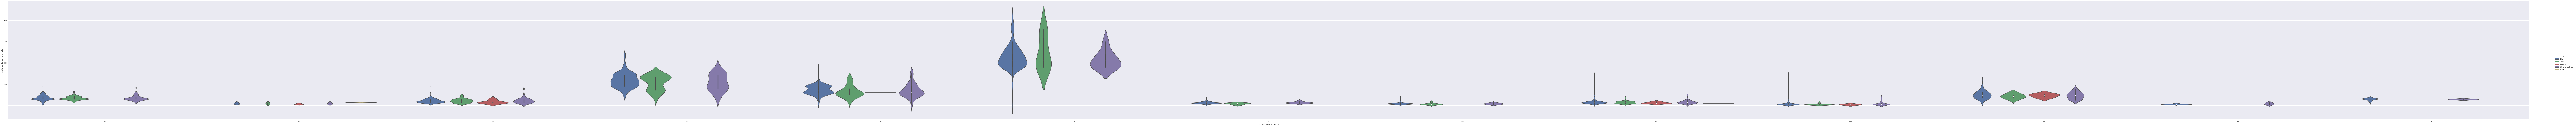

In [378]:
# Plot to understand why average sentence shows higher for White inmates.
sns.catplot(x = 'offense_severity_group', y = 'sentence_to_serve_months', data = prison_df, kind = 'violin', hue = 'race', height = 10, aspect = 20)
plt.show()

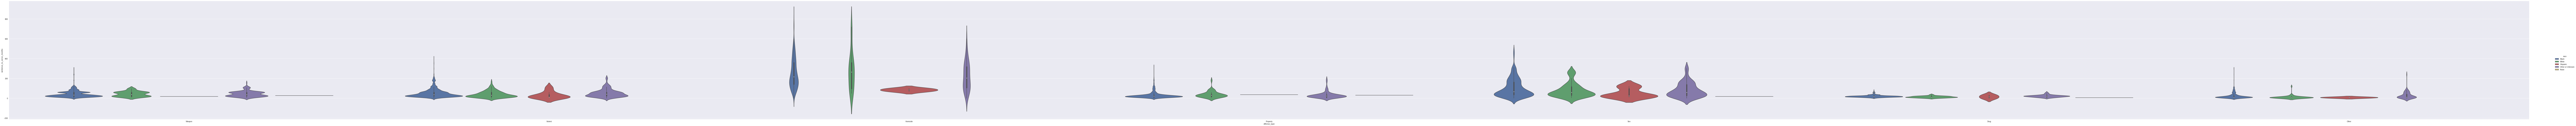

In [379]:
# Additional violin to also look at offense type
sns.catplot(x = 'offense_type', y = 'sentence_to_serve_months', data = prison_df, kind = 'violin', hue = 'race', height = 10, aspect = 20)
plt.show()

**Feature Engineering**

* Reducing offense column into categories based on avg sentence

In [380]:
offense_count = prison_df.groupby('offense')['sentence_to_serve_months'].mean()

In [381]:
offense_count = offense_count.sort_values(ascending = False)

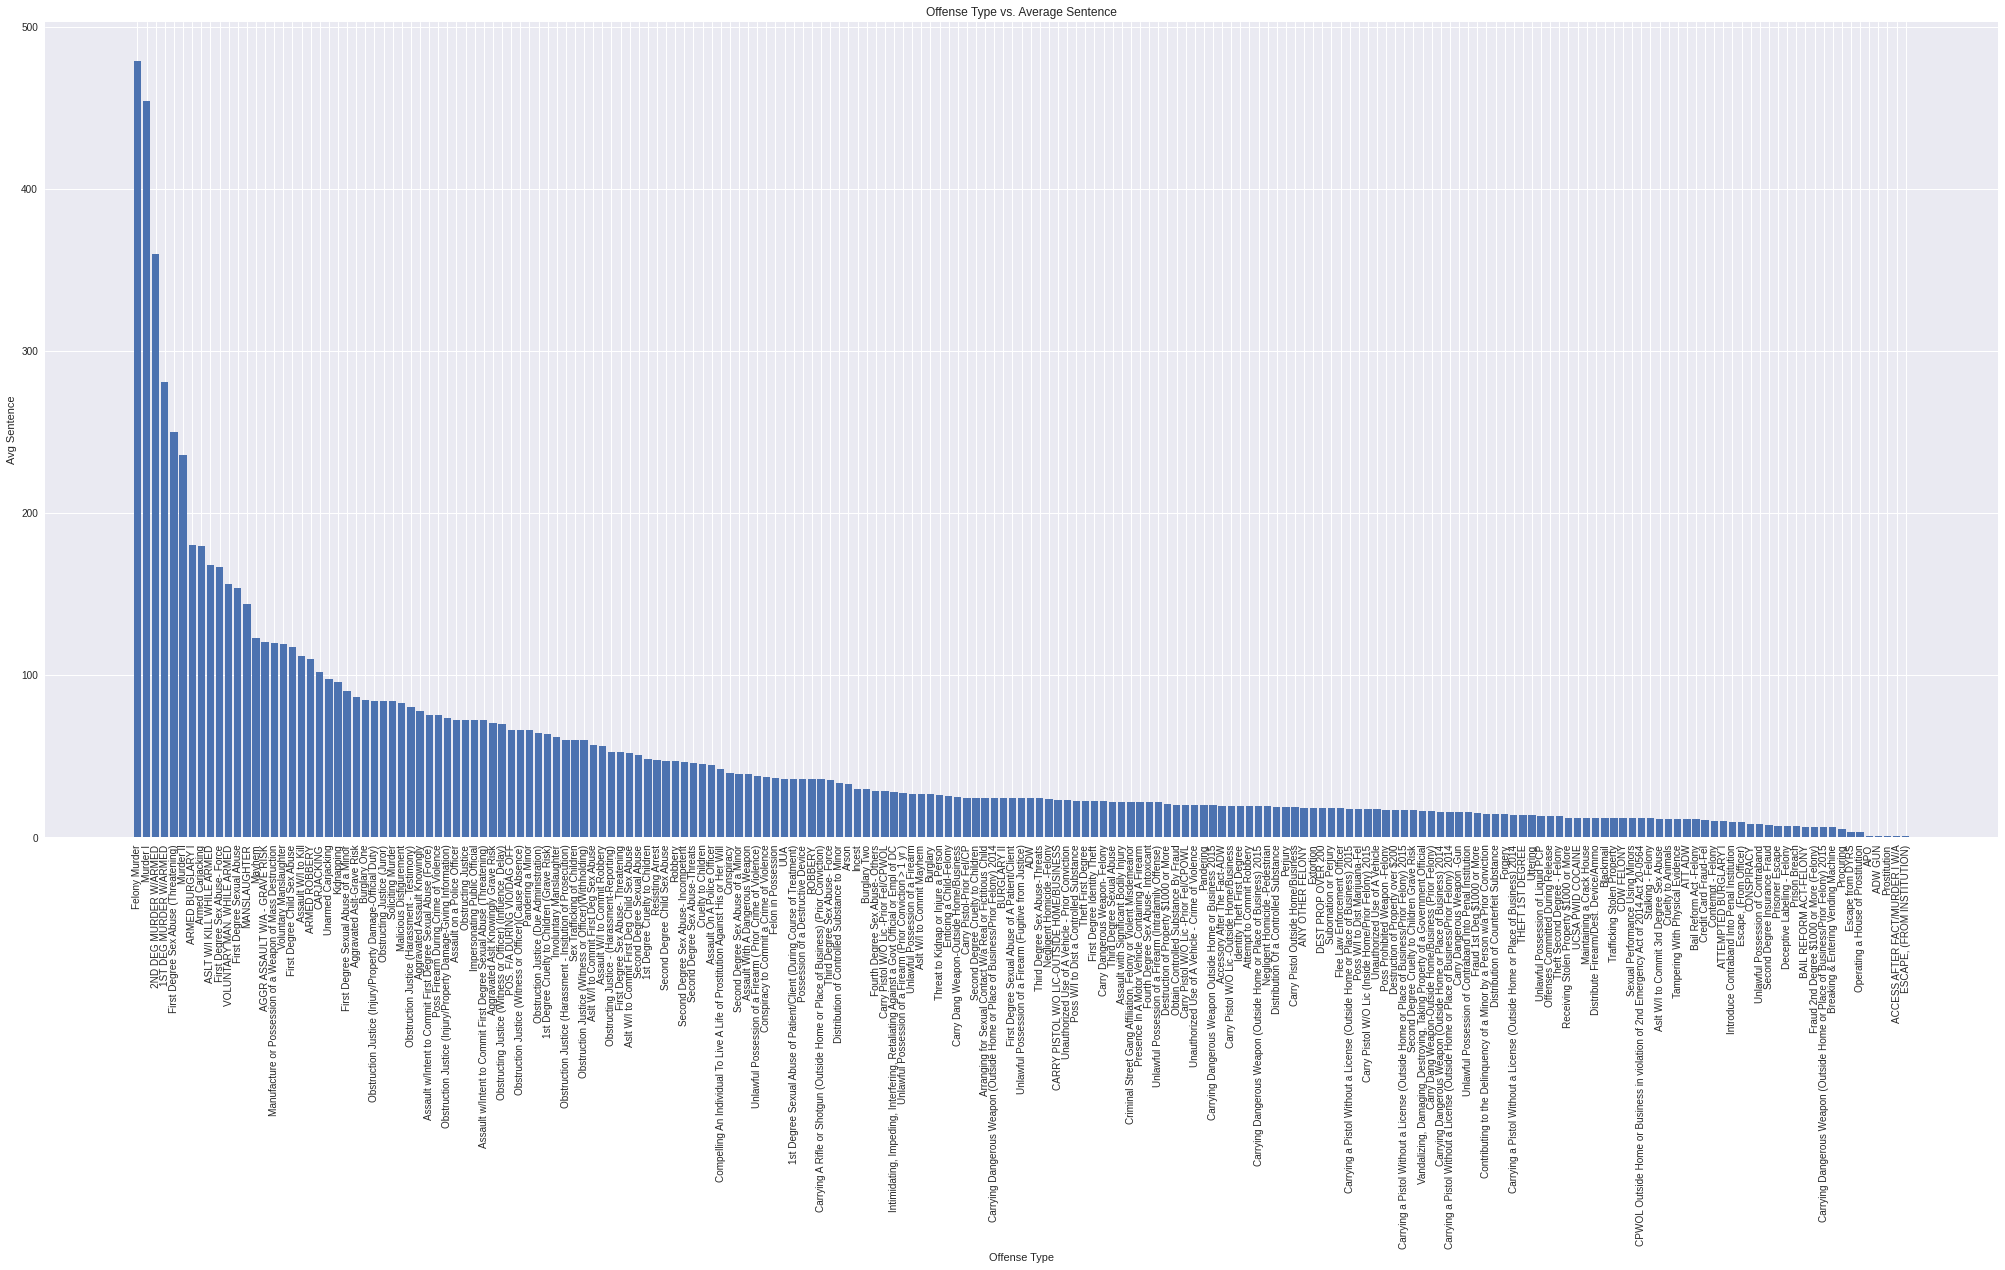

In [382]:
# Plot a offenses on x-axis with average term length for each offense category in decreasing order
# Identify significant drops to create new categories to reduce dimensions 

plt.figure(figsize = (35, 15))
plt.bar(offense_count.index, offense_count)
plt.xticks(rotation = 90)
plt.title('Offense Type vs. Average Sentence')
plt.ylabel('Avg Sentence')
plt.xlabel('Offense Type')
plt.show()

Creating new categories of offense types to reduce dimensionality, based on drops in average sentences observed in plot above.

In [383]:
# Breaks in avg sentence occur at 600, 500, 320, 180, 120, 100, 80, 60, 40, 20, 10, 1

prison_df.loc[prison_df['sentence_to_serve_months'] >= 600, 'offense'] = 'severe_hi'
prison_df.loc[prison_df['sentence_to_serve_months'] < 600, 'offense'] = 'severe_lo'
prison_df.loc[prison_df['sentence_to_serve_months'] < 500, 'offense'] = 'serious_hi'
prison_df.loc[prison_df['sentence_to_serve_months'] < 320, 'offense'] = 'serious_mid'
prison_df.loc[prison_df['sentence_to_serve_months'] < 180, 'offense'] = 'serious_lo'
prison_df.loc[prison_df['sentence_to_serve_months'] < 120, 'offense'] = 'major_hi'
prison_df.loc[prison_df['sentence_to_serve_months'] < 100, 'offense'] = 'major_mid'
prison_df.loc[prison_df['sentence_to_serve_months'] < 80, 'offense'] = 'major_lo'
prison_df.loc[prison_df['sentence_to_serve_months'] < 60, 'offense'] = 'minor_hi'
prison_df.loc[prison_df['sentence_to_serve_months'] < 40, 'offense'] = 'minor_mid'
prison_df.loc[prison_df['sentence_to_serve_months'] < 20, 'offense'] = 'minor_lo'
prison_df.loc[prison_df['sentence_to_serve_months'] < 10, 'offense'] = 'minimum'

In [384]:
# Verify offense types have been reduced to 12 levels
prison_df.offense.value_counts()

minor_mid      4333
minor_lo       3420
major_lo       1656
minimum        1003
minor_hi        970
major_mid       688
serious_lo      494
serious_mid     477
major_hi        273
serious_hi      156
severe_lo        22
severe_hi        17
Name: offense, dtype: int64

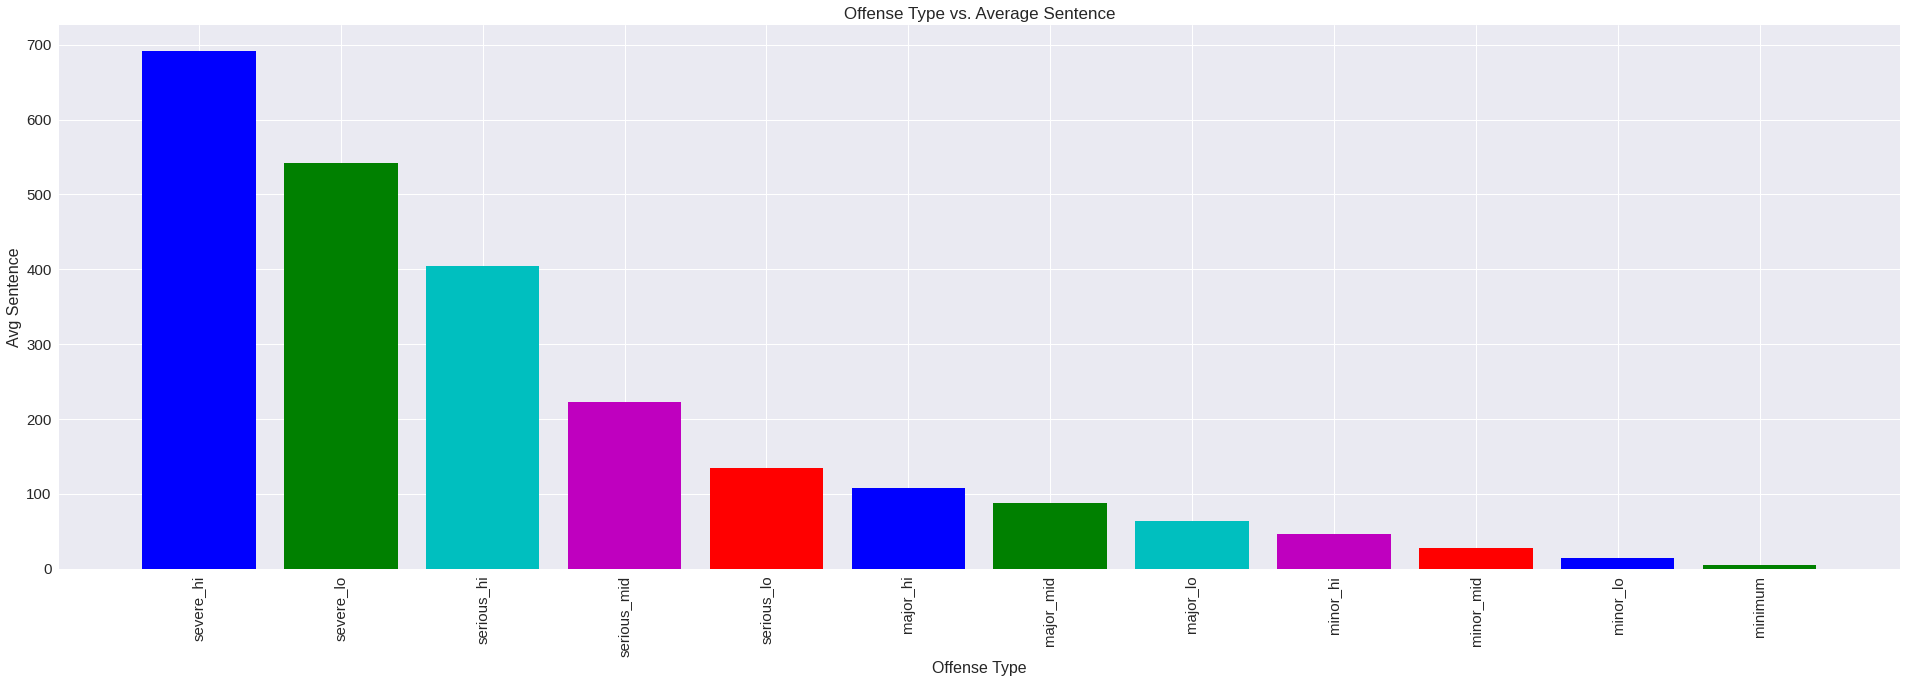

In [385]:
# Plot reduced dimension offense feature
offense_count = prison_df.groupby('offense')['sentence_to_serve_months'].mean()

offense_count = offense_count.sort_values(ascending = False)

plt.figure(figsize = (33, 10))
plt.bar(offense_count.index, offense_count, color = ('b','g','c', 'm', 'r') )
plt.xticks(rotation = 90, size = 15)
plt.yticks(size = 15)
plt.title('Offense Type vs. Average Sentence', size = 17)
plt.ylabel('Avg Sentence', size = 16)
plt.xlabel('Offense Type', size = 16)
plt.show()

Many duplicate offender IDs were identified in data. Will add a new column to detect duplicate offender ID's and assign a multiple_crime boolean value.

In [386]:
# New feature created for multiple crime column using generic_offender_id column data
prison_df['multiple_crime'] = prison_df.duplicated(subset = ['generic_offender_id'])

In [387]:
# Create a dataframe for use in non-linear regression models
prison_nonlin_df = prison_df

In [388]:
# New list of categorical values of interest
categoricals = ['sentence_year', 'race',	'gender', 'age_group', 'offense', 'offense_type', 'homicide_type',	'offense_severity_group', 'sentence_type', 'multiple_crime']

# Convert categorical columns into numeric
for feats in categoricals:
  prison_df = pd.concat([prison_df, pd.get_dummies(prison_df[feats], prefix= str(feats), drop_first = True)], axis = 1)

In [389]:
prison_df.head()

,generic_offender_id,sentence_year,race,gender,age_group,offense,offense_type,homicide_type,offense_severity_group,sentence_type,sentence_to_serve_months,vvca_amt,fine_amt,restitution_amt,fine_suspended_amt,boxcox_sentence,boxcox_vvca,boxcox_fine,boxcox_restitution,boxcox_fine_susp,multiple_crime,sentence_year_2011,sentence_year_2012,sentence_year_2013,sentence_year_2014,sentence_year_2015,sentence_year_2016,sentence_year_2017,sentence_year_2018,race_Black,race_Hispanic,race_Other or Unknown,race_White,gender_M,gender_not_recorded,age_group_18-21,age_group_22-30,age_group_31-40,age_group_41-50,age_group_51-60,age_group_61-70,age_group_71+,offense_major_lo,offense_major_mid,offense_minimum,offense_minor_hi,offense_minor_lo,offense_minor_mid,offense_serious_hi,offense_serious_lo,offense_serious_mid,offense_severe_hi,offense_severe_lo,offense_type_Homicide,offense_type_Other,offense_type_Property,offense_type_Sex,offense_type_Violent,offense_type_Weapon,homicide_type_Murder I,homicide_type_Murder II,homicide_type_Voluntary Manslaughter,homicide_type_not_homicide,offense_severity_group_D2,offense_severity_group_D3,offense_severity_group_D4,offense_severity_group_M1,offense_severity_group_M2,offense_severity_group_M3,offense_severity_group_M4,offense_severity_group_M5,offense_severity_group_M6,offense_severity_group_M7,offense_severity_group_M8,offense_severity_group_M9,multiple_crime_True
15,8258401,2018,Black,M,22-30,minimum,Weapon,not_homicide,M5,Incarceration,1.0,101,1.0,1.0,1.0,0.0,4.38419,0.0,0.0,0.0,False,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
16,8258401,2018,Black,M,22-30,minimum,Weapon,not_homicide,M5,Incarceration,1.0,101,1.0,1.0,1.0,0.0,4.38419,0.0,0.0,0.0,True,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
17,8258401,2018,Black,M,22-30,minimum,Weapon,not_homicide,M5,Incarceration,1.0,101,1.0,1.0,1.0,0.0,4.38419,0.0,0.0,0.0,True,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
18,8258401,2018,Black,M,22-30,minimum,Weapon,not_homicide,M8,Incarceration,1.0,101,1.0,1.0,1.0,0.0,4.38419,0.0,0.0,0.0,True,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
19,8258401,2018,Black,M,22-30,minimum,Violent,not_homicide,M6,Incarceration,1.0,101,1.0,1.0,1.0,0.0,4.38419,0.0,0.0,0.0,True,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


**Feature Selection** - Setup dataframe for modeling

In [390]:
prison_df.drop(columns = ['sentence_year', 'race',	'gender', 'age_group', 'offense', 'offense_type', 'homicide_type',	'offense_severity_group', 'sentence_type', 'multiple_crime'], inplace = True)

In [391]:
prison_df.drop(columns = ['generic_offender_id', 'sentence_to_serve_months',	'vvca_amt',	'fine_amt',	'restitution_amt', 'fine_suspended_amt'], inplace = True)

In [392]:
prison_df.head()

,boxcox_sentence,boxcox_vvca,boxcox_fine,boxcox_restitution,boxcox_fine_susp,sentence_year_2011,sentence_year_2012,sentence_year_2013,sentence_year_2014,sentence_year_2015,sentence_year_2016,sentence_year_2017,sentence_year_2018,race_Black,race_Hispanic,race_Other or Unknown,race_White,gender_M,gender_not_recorded,age_group_18-21,age_group_22-30,age_group_31-40,age_group_41-50,age_group_51-60,age_group_61-70,age_group_71+,offense_major_lo,offense_major_mid,offense_minimum,offense_minor_hi,offense_minor_lo,offense_minor_mid,offense_serious_hi,offense_serious_lo,offense_serious_mid,offense_severe_hi,offense_severe_lo,offense_type_Homicide,offense_type_Other,offense_type_Property,offense_type_Sex,offense_type_Violent,offense_type_Weapon,homicide_type_Murder I,homicide_type_Murder II,homicide_type_Voluntary Manslaughter,homicide_type_not_homicide,offense_severity_group_D2,offense_severity_group_D3,offense_severity_group_D4,offense_severity_group_M1,offense_severity_group_M2,offense_severity_group_M3,offense_severity_group_M4,offense_severity_group_M5,offense_severity_group_M6,offense_severity_group_M7,offense_severity_group_M8,offense_severity_group_M9,multiple_crime_True
15,0.0,4.38419,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
16,0.0,4.38419,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
17,0.0,4.38419,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
18,0.0,4.38419,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
19,0.0,4.38419,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


**Modelling**

**Regression Models Employed:**
* Linear Regression
* Lasso
* Ridge
* ElasticNet
* OLS
* SVM
* Random Forest

**Preparing Data for Models**
* Separate features(X) and labels(y)
* Create train and test sets


In [393]:
# Import train_test_split
from sklearn.model_selection import train_test_split 

X = prison_df.drop(columns = ['boxcox_sentence'])
y = prison_df.boxcox_sentence

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, test_size = 0.20, random_state = 2)

In [394]:
# Verify split
print(X_train.shape[0], y_train.shape[0], X_test.shape[0], y_test.shape[0])

10807 10807 2702 2702


**Linear Regression Model**

In [395]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

# Create model
lrm = LinearRegression()

# Train
lrm.fit(X_train,y_train)

# Predictions
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.940970886549233
-----Test set statistics-----
R-squared of the model in the test set is: 0.9463072472529384
Mean absolute error of the prediction is: 0.14985235551691103
Mean squared error of the prediction is: 0.04954961927206509
Root mean squared error of the prediction is: 0.2225974377032788
Mean absolute percentage error of the prediction is: inf


In [396]:
# Cross Validation
from sklearn.model_selection import cross_val_score

print('\nCross Val for linear regr:')
print(cross_val_score(lrm, X, y, cv = 10, scoring = 'r2'))
print('\nCross Validation Mean Score: ')
#print(cross_val_score(lrm, X, y, cv = 10).mean())


Cross Val for linear regr:
[-2.27334537e+23  9.37351947e-01  9.24097250e-01  9.54928625e-01
  9.40737872e-01  9.61601143e-01  9.43913885e-01  9.56207385e-01
 -2.44337212e+17 -7.07775445e+13]

Cross Validation Mean Score: 


Identify significant features - observe prediction effects upon the removal of non-significants

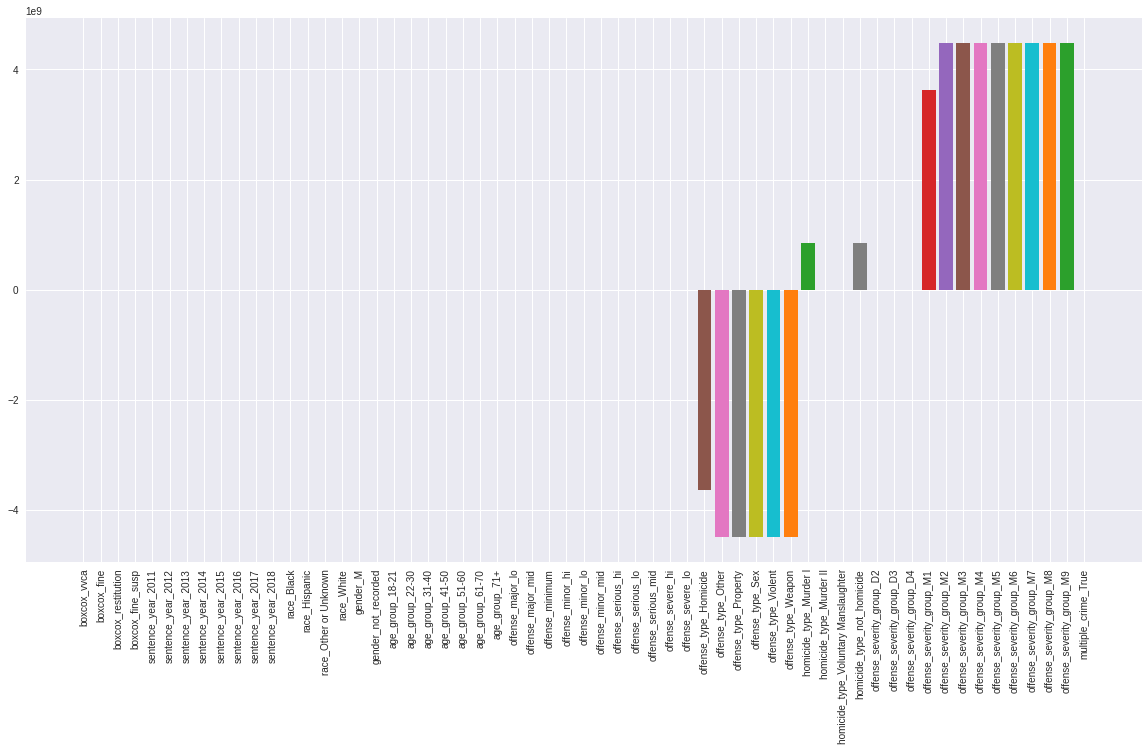

In [397]:
# Putting together the coefficient and their corresponding variable names  
lrm_coefficient = pd.DataFrame() 
lrm_coefficient["Columns"] = X_train.columns 
lrm_coefficient['Coefficient Estimate'] = pd.Series(lrm.coef_) 

# Plotting the coefficient score 
fig, ax = plt.subplots(figsize =(20, 10)) 
  
color =['tab:gray', 'tab:blue', 'tab:orange',  
'tab:green', 'tab:red', 'tab:purple', 'tab:brown',  
'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',  
'tab:orange', 'tab:green', 'tab:blue', 'tab:olive'] 
  
ax.bar(lrm_coefficient["Columns"],  
lrm_coefficient['Coefficient Estimate'],  
color = color) 
  
ax.spines['top'].set_position('zero') 
plt.xticks(rotation = 90)  
plt.style.use('ggplot') 
plt.show() 

In [398]:
sig_feats = ['offense_type_Homicide', 'offense_type_Other','offense_type_Property', 'offense_type_Sex', 'offense_type_Violent', 'offense_type_Weapon', 'homicide_type_Murder I',
       'homicide_type_Murder II', 'homicide_type_Voluntary Manslaughter', 'homicide_type_not_homicide', 'offense_severity_group_D2', 'offense_severity_group_D3', 
        'offense_severity_group_D4', 'offense_severity_group_M1', 'offense_severity_group_M2', 'offense_severity_group_M3', 'offense_severity_group_M4',
       'offense_severity_group_M5', 'offense_severity_group_M6', 'offense_severity_group_M7', 'offense_severity_group_M8', 'offense_severity_group_M9']

In [399]:
# New Model with only the significant features considered
Xlrm = prison_df[sig_feats]
ylrm = prison_df.boxcox_sentence

# Split data
X_trainlrm, X_testlrm, y_trainlrm, y_testlrm = train_test_split(Xlrm, ylrm, train_size = 0.80, test_size = 0.20, random_state = 2)

In [400]:
# Create model
lrm2 = LinearRegression()

# Train
lrm2.fit(X_trainlrm,y_trainlrm)

# Predictions
y_preds_trainlrm = lrm2.predict(X_trainlrm)
y_preds_testlrm = lrm2.predict(X_testlrm)

print("R-squared of the model in the training set is: {}".format(lrm2.score(X_trainlrm, y_trainlrm)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm2.score(X_testlrm, y_testlrm)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_testlrm, y_preds_testlrm)))
print("Mean squared error of the prediction is: {}".format(mse(y_testlrm, y_preds_testlrm)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_testlrm, y_preds_testlrm)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_testlrm - y_preds_testlrm) / y_testlrm)) * 100))

R-squared of the model in the training set is: 0.68057822249349
-----Test set statistics-----
R-squared of the model in the test set is: 0.7156273968348115
Mean absolute error of the prediction is: 0.3574738732024316
Mean squared error of the prediction is: 0.2624293502815839
Root mean squared error of the prediction is: 0.5122785865928654
Mean absolute percentage error of the prediction is: inf


Will not remove the features

Employ regularization linear regression models

**Lasso** - force small parameter estimates to be equal to zero

In [401]:
# Ignore convergence warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [402]:
from sklearn.linear_model import Lasso

# Establish alpha
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

# Create model with cross validation
lasso_reg = LassoCV(alphas = alphas, cv = 5)

# Train
lasso_reg.fit(X_train, y_train)

print("Best alpha value is: {}".format(lasso_reg.alpha_))

Best alpha value is: 1e-05


In [403]:
# predict
train_predictionsLS = lasso_reg.predict(X_train)
test_predictionsLS = lasso_reg.predict(X_test)

# print metrics
print("Best alpha value is: {}".format(lasso_reg.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_reg.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_reg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test,test_predictionsLS)))
print("Mean squared error of the prediction is: {}".format(mse(y_test,test_predictionsLS)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test,test_predictionsLS)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test -test_predictionsLS) / y_test)) * 100))


Best alpha value is: 1e-05
R-squared of the model in training set is: 0.9409383620206363
-----Test set statistics-----
R-squared of the model in test set is: 0.9463549796800741
Mean absolute error of the prediction is: 0.14981562681189872
Mean squared error of the prediction is: 0.04950557005740372
Root mean squared error of the prediction is: 0.222498472033863
Mean absolute percentage error of the prediction is: inf


In [404]:
# Cross validate
from sklearn.model_selection import cross_val_score
print('\nCross Val for Lasso regr:')
print(cross_val_score(lasso_reg, X, y, cv = 10))
print('\nCross Validation Mean Score: ')
print(cross_val_score(lasso_reg, X, y, cv = 10).mean())


Cross Val for Lasso regr:
[0.92559562 0.93726235 0.92388294 0.95482434 0.94091453 0.9620286
 0.94393514 0.95615694 0.93097848 0.91057988]

Cross Validation Mean Score: 
0.9386158815493213


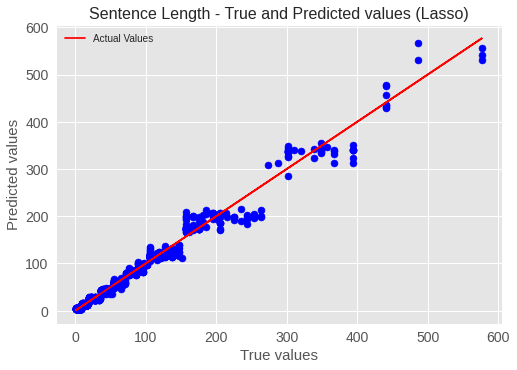

In [ ]:
plt.scatter(np.exp(y_test), np.exp(test_predictionsLS), c = 'b') #Plot the actual y values versus the predicted y values
plt.plot(np.exp(y_test), np.exp(y_test), color = "red", label = 'Actual Values') # Plot the line using actual targets
plt.xlabel("True values", size = 15)
plt.ylabel("Predicted values", size = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.title("Sentence Length - True and Predicted values (Lasso)", size = 16)
plt.legend()
plt.show()

**Ridge**

In [405]:
from sklearn.linear_model import Ridge

# Create model with cross validation of 5
ridge_reg = RidgeCV(alphas = alphas, cv =5)

# Train the model
ridge_reg.fit(X_train, y_train)


print("Best alpha value is: {}".format(ridge_reg.alpha_))

Best alpha value is: 0.01


In [406]:
# Ridge evaluation with test set

# make predictions with both train and test features
train_predictions_r = ridge_reg.predict(X_train)
test_predictions_r = ridge_reg.predict(X_test)

# print metrics
print("Best alpha value is: {}".format(ridge_reg.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_reg.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_reg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test,test_predictions_r)))
print("Mean squared error of the prediction is: {}".format(mse(y_test,test_predictions_r)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test,test_predictions_r)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test -test_predictions_r) / y_test)) * 100))

Best alpha value is: 0.01
R-squared of the model in training set is: 0.9409525553899397
-----Test set statistics-----
R-squared of the model in test set is: 0.9463409739831943
Mean absolute error of the prediction is: 0.14980286137408289
Mean squared error of the prediction is: 0.049518495022367076
Root mean squared error of the prediction is: 0.22252751520287795
Mean absolute percentage error of the prediction is: inf


In [ ]:
# Cross Validate
print('\nCross Val for Ridge regr:')
print(cross_val_score(ridge_reg, X, y, cv = 10))
print('\nCross Validation Mean Score: ')
print(cross_val_score(ridge_reg, X, y, cv = 10).mean())


Cross Val for Ridge regr:
[0.92535737 0.93705468 0.92410927 0.95494704 0.94084809 0.96187645
 0.94401923 0.95622686 0.93062705 0.91041389]

Cross Validation Mean Score: 
0.938547992948781


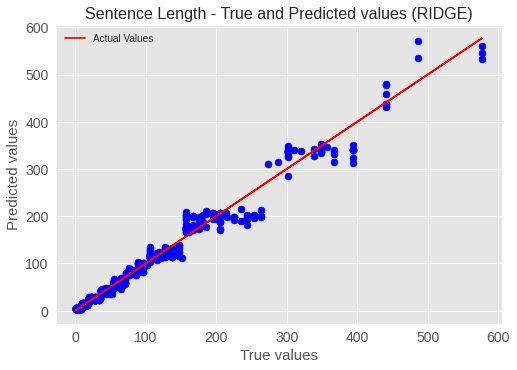

In [ ]:
# Plot the actual y values versus the predicted y values
plt.scatter(np.exp(y_test), np.exp(test_predictions_r), c = 'b') 
plt.plot(np.exp(y_test), np.exp(y_test), color = "red", label = 'Actual Values')
plt.xlabel("True values", size = 15)
plt.ylabel("Predicted values", size = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.title("Sentence Length - True and Predicted values (RIDGE)", size = 16)
plt.legend()
plt.show()

**Elastic Net**

In [407]:
# Create model with cross validation
elastic_reg = ElasticNetCV(alphas = alphas, cv = 5)

# Train
elastic_reg.fit(X_train, y_train)

print("Best alpha value is: {}".format(elastic_reg.alpha_))

Best alpha value is: 1e-05


In [408]:
# predict
train_predictionsEN = elastic_reg.predict(X_train)
test_predictionsEN = elastic_reg.predict(X_test)

# print metrics
print("Best alpha value is: {}".format(elastic_reg.alpha_))
print("R-squared of the model in training set is: {}".format(elastic_reg.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elastic_reg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test,test_predictionsEN)))
print("Mean squared error of the prediction is: {}".format(mse(y_test,test_predictionsEN)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test,test_predictionsEN)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test -test_predictionsEN) / y_test)) * 100))

Best alpha value is: 1e-05
R-squared of the model in training set is: 0.9409435045063902
-----Test set statistics-----
R-squared of the model in test set is: 0.946351378219881
Mean absolute error of the prediction is: 0.14980793086476482
Mean squared error of the prediction is: 0.049508893615468084
Root mean squared error of the prediction is: 0.22250594062961124
Mean absolute percentage error of the prediction is: inf


In [409]:
# Cross Validate
print('\nCross Val for ElasticNet regr:')
print(cross_val_score(elastic_reg, X, y, cv = 10))
print('\nCross Validation Mean Score: ')
print(cross_val_score(elastic_reg, X, y, cv = 10).mean())


Cross Val for ElasticNet regr:
[0.92536503 0.93710191 0.92414218 0.95495439 0.94085925 0.96188127
 0.94403605 0.95623182 0.93045364 0.91040252]

Cross Validation Mean Score: 
0.9385428062484646


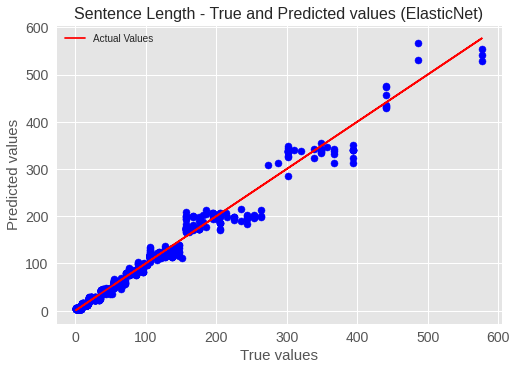

In [ ]:
# Plot the actual y values versus the predicted y values
plt.scatter(np.exp(y_test), np.exp(test_predictionsEN), c = 'b') 
plt.plot(np.exp(y_test), np.exp(y_test), color = "red", label = 'Actual Values')
plt.xlabel("True values", size = 15)
plt.ylabel("Predicted values", size = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.title("Sentence Length - True and Predicted values (ElasticNet)", size = 16)
plt.legend()
plt.show()

**OLS**

In [ ]:
# Create OLS model with statsmodel
import statsmodels.api as sm

# Start by adding constant
X_train1 = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train1).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        boxcox_sentence   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     3006.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:31:41   Log-Likelihood:                 592.68
No. Observations:               10807   AIC:                            -1069.
Df Residuals:                   10749   BIC:                            -646.7
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    4.2624      0.136     31.315      0.000       3.996       4.529
boxcox_vvca                              0.0340      0.005      6.950      0.000       0.024       0.044
boxcox_fine                            -20.5517     11.030     -1.863      0.062     -42.173       1.069
boxcox_restitution                       0.0634      0.160      0.395      0.693      -0.251       0.378
boxcox_fine_susp                        42.2855    467.465      0.090      0.928    -874.033     958.604
sentence_year_2011                       0.0085      0.008      1.066      0.287      -0.007       0.024
sentence_year_2012                       0.0021      0.008      0.259      0.795      -0.014       0.018
sentence_year_2013                       0.0069      0.009      0.768      0.443      -0.011       0.025
sentence_year_2014                      -0.0143      0.009     -1.641      0.101      -0.031       0.003
sentence_year_2015                      -0.0284      0.010     -2.800      0.005      -0.048      -0.009
sentence_year_2016                      -0.0093      0.010     -0.899      0.369      -0.030       0.011
sentence_year_2017                       0.0054      0.010      0.561      0.575      -0.014       0.024
sentence_year_2018                      -0.0384      0.010     -3.800      0.000      -0.058      -0.019
race_Black                              -0.1489      0.115     -1.293      0.196      -0.374       0.077
race_Hispanic                           -0.2278      0.127     -1.799      0.072      -0.476       0.020
race_Other or Unknown                   -0.1573      0.115     -1.363      0.173      -0.384       0.069
race_White                              -0.1518      0.116     -1.312      0.190      -0.379       0.075
gender_M                                 0.0446      0.011      3.911      0.000       0.022       0.067
gender_not_recorded                      0.0675      0.024      2.794      0.005       0.020       0.115
age_group_18-21                          0.0018      0.013      0.140      0.889      -0.023       0.026
age_group_22-30                          0.0076      0.012      0.612      0.540      -0.017       0.032
age_group_31-40                          0.0279      0.013      2.135      0.033       0.002       0.053
age_group_41-50                          0.0402      0.014      2.939      0.003       0.013       0.067
age_group_51-60                          0.0229      0.015      1.521      0.128      -0.007       0.052
age_group_61-70                          0.0220      0.028      0.774      0.439      -0.034       0.078
age_group_71+                           -0.1120      0.164     -0.685      0.494      -0.433       0.209
offense_major_lo                      

In [ ]:
# Add constant for prediction
X_test1 = sm.add_constant(X_test)

# Predict with test set
ypred_ols = results.predict(X_test1)

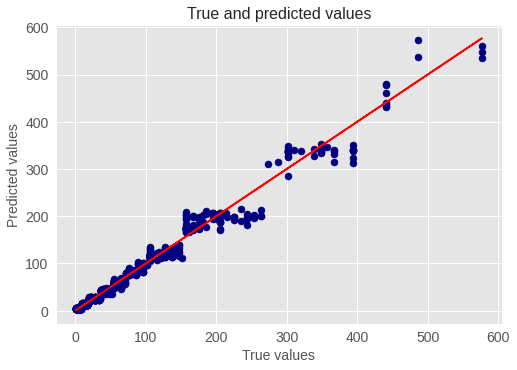

Mean absolute error of the prediction is: 0.14985248190333897
Mean squared error of the prediction is: 0.04954955658264441
Root mean squared error of the prediction is: 0.22259729688979696
Mean absolute percentage error of the prediction is: inf


In [ ]:
# Plot the actual y values versus the predicted y values
plt.scatter(np.exp(y_test), np.exp(ypred_ols), color = 'navy') 
plt.plot(np.exp(y_test), np.exp(y_test), color = "red") 
plt.xlabel("True values", size = 14)
plt.ylabel("Predicted values", size = 14)
plt.title("True and predicted values", size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, ypred_ols)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, ypred_ols)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, ypred_ols)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - ypred_ols) / y_test)) * 100))


In [ ]:
# score for OLS
from sklearn.metrics import r2_score
r2_score(y_test, ypred_ols)

0.9463073151841881

All linear regression models had very similar performances with 94.6% score on test set and 0.049 as the MSE.

From the OLS summary p-value evaluation, **race is not significant** in determining the prediction.

In [ ]:
# Create a dataframe without the race column to run with best linear regression model (OLS)
prison_ols = prison_nonlin_df

# New list of categorical values of interest removing race and multiple_crime 
categoricals = ['sentence_year', 'gender', 'age_group', 'offense', 'offense_type', 'homicide_type',	'offense_severity_group', 'sentence_type', 'multiple_crime']

# Convert categorical columns into numeric
for feats in categoricals:
  prison_ols = pd.concat([prison_ols, pd.get_dummies(prison_ols[feats], prefix = str(feats), drop_first = True)], axis = 1)

In [ ]:
# Drop columns not in use to clean dataframe
prison_ols.drop(columns = ['sentence_year', 'race',	'gender', 'age_group', 'offense', 'offense_type', 'homicide_type',	'offense_severity_group', 'sentence_type', 'multiple_crime'], inplace = True)
prison_ols.drop(columns = ['generic_offender_id', 'sentence_to_serve_months',	'vvca_amt',	'fine_amt',	'restitution_amt', 'fine_suspended_amt'], inplace = True)

In [ ]:
# Separate feature and target columns for model
X_ols = prison_ols.drop(columns = ['boxcox_sentence'])
y_ols = prison_ols.boxcox_sentence

# Split data
X_ols_train, X_ols_test, y_ols_train, y_ols_test = train_test_split(X_ols, y_ols, train_size = 0.80, test_size = 0.20, random_state = 2)

In [ ]:
# Start by adding constant
X_ols_train1 = sm.add_constant(X_ols_train)

results_ols = sm.OLS(y_ols_train, X_ols_train1).fit()

results_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        boxcox_sentence   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     3233.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:44:46   Log-Likelihood:                 590.36
No. Observations:               10807   AIC:                            -1073.
Df Residuals:                   10753   BIC:                            -679.2
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    4.1449      0.102     40.811      0.000       3.946       4.344
boxcox_vvca                              0.0338      0.005      6.913      0.000       0.024       0.043
boxcox_fine                            -20.4341     11.030     -1.853      0.064     -42.054       1.186
boxcox_restitution                       0.0659      0.160      0.411      0.681      -0.248       0.380
boxcox_fine_susp                        46.4977    467.453      0.099      0.921    -869.796     962.791
sentence_year_2011                       0.0087      0.008      1.093      0.274      -0.007       0.024
sentence_year_2012                       0.0021      0.008      0.255      0.798      -0.014       0.018
sentence_year_2013                       0.0065      0.009      0.722      0.470      -0.011       0.024
sentence_year_2014                      -0.0143      0.009     -1.646      0.100      -0.031       0.003
sentence_year_2015                      -0.0287      0.010     -2.829      0.005      -0.049      -0.009
sentence_year_2016                      -0.0088      0.010     -0.850      0.395      -0.029       0.011
sentence_year_2017                       0.0057      0.010      0.592      0.554      -0.013       0.025
sentence_year_2018                      -0.0379      0.010     -3.757      0.000      -0.058      -0.018
gender_M                                 0.0443      0.011      3.890      0.000       0.022       0.067
gender_not_recorded                      0.0654      0.024      2.720      0.007       0.018       0.113
age_group_18-21                          0.0020      0.013      0.160      0.873      -0.023       0.027
age_group_22-30                          0.0077      0.012      0.623      0.533      -0.017       0.032
age_group_31-40                          0.0284      0.013      2.180      0.029       0.003       0.054
age_group_41-50                          0.0404      0.014      2.956      0.003       0.014       0.067
age_group_51-60                          0.0233      0.015      1.547      0.122      -0.006       0.053
age_group_61-70                          0.0226      0.028      0.796      0.426      -0.033       0.078
age_group_71+                           -0.1152      0.163     -0.705      0.481      -0.436       0.205
offense_major_lo                        -0.4964      0.018    -27.754      0.000      -0.532      -0.461
offense_major_mid                       -0.1828      0.019     -9.621      0.000      -0.220      -0.146
offense_minimum                         -2.8962      0.021   -136.572      0.000      -2.938      -2.855
offense_minor_hi                        -0.8043      0.020    -41.045      0.000      -0.843      -0.766
offense_minor_lo                      

In [ ]:
# Predictions
# add constant for prediction
X_ols_test1 = sm.add_constant(X_ols_test)

ypred_ols2 = results_ols.predict(X_ols_test1)

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_ols_test, ypred_ols2)))
print("Mean squared error of the prediction is: {}".format(mse(y_ols_test, ypred_ols2)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_ols_test, ypred_ols2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_ols_test - ypred_ols2) / y_ols_test)) * 100))

#OLS Score
print('R2 Score with Test Set: ', r2_score(y_ols_test, ypred_ols2))

Mean absolute error of the prediction is: 0.14985426049346728
Mean squared error of the prediction is: 0.04951192893851617
Root mean squared error of the prediction is: 0.22251276129363046
Mean absolute percentage error of the prediction is: inf
R2 Score with Test Set:  0.9463480890957198


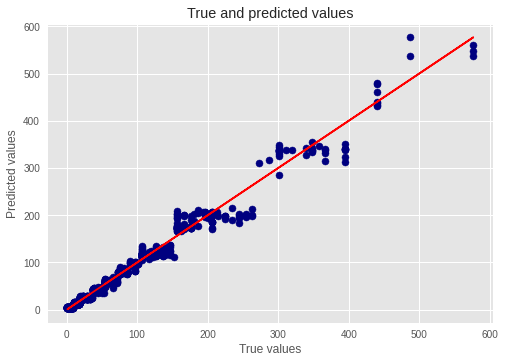

In [ ]:
# Plot the actual y values versus the predicted y values
plt.scatter(np.exp(y_ols_test), np.exp(ypred_ols2), color = "navy") 
plt.plot(np.exp(y_ols_test), np.exp(y_ols_test), color = "red") 
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and predicted values")
plt.show()

Interested in also predicting incarceration terms outside of the 2010 - 2018 timeframe
* Will remove sentence year 
* Also will remove multiple_crime feature


In [ ]:
# Create a dataframe without sentence year or multiple crime for use in OLS model
prison_ols2 = prison_ols.loc[:,~prison_ols.columns.str.contains('sentence_year_', case = False)] 
prison_ols2 = prison_ols2.loc[:,~prison_ols2.columns.str.contains('multiple_crime', case = False)] 

# Separate feature and target columns for model
X_ols2 = prison_ols2.drop(columns = ['boxcox_sentence'])
y_ols2 = prison_ols2.boxcox_sentence

# Split data
X_ols_train2, X_ols_test2, y_ols_train2, y_ols_test2 = train_test_split(X_ols2, y_ols2, train_size = 0.80, test_size = 0.20, random_state = 2)

In [ ]:
# Start by adding constant for new OLS model
X_ols_train3 = sm.add_constant(X_ols_train2)

results_ols2 = sm.OLS(y_ols_train2, X_ols_train3).fit()

results_ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        boxcox_sentence   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     3880.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:46:05   Log-Likelihood:                 568.06
No. Observations:               10807   AIC:                            -1046.
Df Residuals:                   10762   BIC:                            -718.2
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    4.1402      0.102     40.774      0.000       3.941       4.339
boxcox_vvca                              0.0348      0.005      7.142      0.000       0.025       0.044
boxcox_fine                            -19.4578     11.034     -1.763      0.078     -41.086       2.170
boxcox_restitution                       0.0512      0.160      0.320      0.749      -0.263       0.365
boxcox_fine_susp                        41.0439    468.150      0.088      0.930    -876.616     958.704
gender_M                                 0.0429      0.011      3.771      0.000       0.021       0.065
gender_not_recorded                      0.0695      0.024      2.889      0.004       0.022       0.117
age_group_18-21                          0.0009      0.013      0.076      0.940      -0.024       0.026
age_group_22-30                          0.0044      0.012      0.355      0.723      -0.020       0.029
age_group_31-40                          0.0240      0.013      1.844      0.065      -0.002       0.049
age_group_41-50                          0.0377      0.014      2.761      0.006       0.011       0.064
age_group_51-60                          0.0181      0.015      1.209      0.227      -0.011       0.048
age_group_61-70                          0.0124      0.028      0.439      0.660      -0.043       0.068
age_group_71+                           -0.1105      0.164     -0.675      0.499      -0.431       0.210
offense_major_lo                        -0.5006      0.018    -27.999      0.000      -0.536      -0.466
offense_major_mid                       -0.1851      0.019     -9.741      0.000      -0.222      -0.148
offense_minimum                         -2.9052      0.021   -137.733      0.000      -2.947      -2.864
offense_minor_hi                        -0.8067      0.020    -41.212      0.000      -0.845      -0.768
offense_minor_lo                        -1.8768      0.019    -96.383      0.000      -1.915      -1.839
offense_minor_mid                       -1.2745      0.019    -67.298      0.000      -1.312      -1.237
offense_serious_hi                       1.0499      0.048     21.784      0.000       0.955       1.144
offense_serious_lo                       0.1749      0.020      8.582      0.000       0.135       0.215
offense_serious_mid                      0.5726      0.023     24.889      0.000       0.528       0.618
offense_severe_hi                        1.5074      0.085     17.691      0.000       1.340       1.674
offense_severe_lo                        1.3207      0.080     16.583      0.000       1.165       1.477
offense_type_Homicide                    0.0931      0.101      0.924      0.356      -0.104       0.291
offense_type_Other                    

In [ ]:
# Predictions
# Add constant for prediction
X_ols_test4 = sm.add_constant(X_ols_test2)

ypred_ols3 = results_ols2.predict(X_ols_test4)

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_ols_test2, ypred_ols3)))
print("Mean squared error of the prediction is: {}".format(mse(y_ols_test2, ypred_ols3)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_ols_test2, ypred_ols3)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_ols_test2 - ypred_ols3) / y_ols_test2)) * 100))

#OLS Score
print('R2 Score with Test Set: ', r2_score(y_ols_test2, ypred_ols3))

Mean absolute error of the prediction is: 0.1497430362260049
Mean squared error of the prediction is: 0.04930668986565079
Root mean squared error of the prediction is: 0.2220510974205054
Mean absolute percentage error of the prediction is: inf
R2 Score with Test Set:  0.9465704894078774


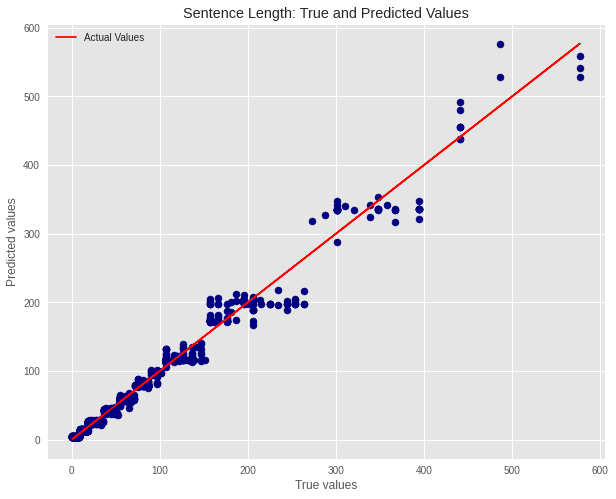

In [ ]:
plt.figure(figsize = (10, 8))
plt.scatter(np.exp(y_ols_test2), np.exp(ypred_ols3), color = "navy") #Plot the actual y values versus the predicted y values
plt.plot(np.exp(y_ols_test2), np.exp(y_ols_test2), color = "red", label = 'Actual Values') # Plot the line using actual targets
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Sentence Length: True and Predicted Values")
plt.legend()
plt.show()

No difference in performance when removing race feature due to lopsided race distributions.

**FOR MODELS AFTER LINEAR REGRESSION** - Adjust table to drop first when creating dummies (Will remove race and multiple_crime)

In [ ]:
prison_nonlin_df.head()

,generic_offender_id,sentence_year,race,gender,age_group,offense,offense_type,homicide_type,offense_severity_group,sentence_type,sentence_to_serve_months,vvca_amt,fine_amt,restitution_amt,fine_suspended_amt,boxcox_sentence,boxcox_vvca,boxcox_fine,boxcox_restitution,boxcox_fine_susp,multiple_crime
15,8258401,2018,Black,M,22-30,minimum,Weapon,not_homicide,M5,Incarceration,1.0,101,1.0,1.0,1.0,0.0,4.38419,0.0,0.0,0.0,False
16,8258401,2018,Black,M,22-30,minimum,Weapon,not_homicide,M5,Incarceration,1.0,101,1.0,1.0,1.0,0.0,4.38419,0.0,0.0,0.0,True
17,8258401,2018,Black,M,22-30,minimum,Weapon,not_homicide,M5,Incarceration,1.0,101,1.0,1.0,1.0,0.0,4.38419,0.0,0.0,0.0,True
18,8258401,2018,Black,M,22-30,minimum,Weapon,not_homicide,M8,Incarceration,1.0,101,1.0,1.0,1.0,0.0,4.38419,0.0,0.0,0.0,True
19,8258401,2018,Black,M,22-30,minimum,Violent,not_homicide,M6,Incarceration,1.0,101,1.0,1.0,1.0,0.0,4.38419,0.0,0.0,0.0,True


In [ ]:
# New list of categorical values of interest (remove race and multiple_crime)
categoricals = ['sentence_year', 'gender', 'age_group', 'offense', 'offense_type', 'homicide_type',	'offense_severity_group', 'sentence_type']

# Convert categorical columns into numeric
for feats in categoricals:
  prison_nonlin_df = pd.concat([prison_nonlin_df, pd.get_dummies(prison_nonlin_df[feats], prefix= str(feats), drop_first = False)], axis = 1)

In [ ]:
# Drop columns not in use to clean dataframe
prison_nonlin_df.drop(columns = ['sentence_year', 'race',	'gender', 'age_group', 'offense', 'offense_type', 'homicide_type',	'offense_severity_group', 'sentence_type', 'multiple_crime'], inplace = True)
prison_nonlin_df.drop(columns = ['generic_offender_id', 'sentence_to_serve_months',	'vvca_amt',	'fine_amt',	'restitution_amt', 'fine_suspended_amt'], inplace = True)

In [ ]:
prison_nonlin_df.head()

,boxcox_sentence,boxcox_vvca,boxcox_fine,boxcox_restitution,boxcox_fine_susp,sentence_year_2010,sentence_year_2011,sentence_year_2012,sentence_year_2013,sentence_year_2014,sentence_year_2015,sentence_year_2016,sentence_year_2017,sentence_year_2018,gender_F,gender_M,gender_not_recorded,age_group_15-17,age_group_18-21,age_group_22-30,age_group_31-40,age_group_41-50,age_group_51-60,age_group_61-70,age_group_71+,offense_major_hi,offense_major_lo,offense_major_mid,offense_minimum,offense_minor_hi,offense_minor_lo,offense_minor_mid,offense_serious_hi,offense_serious_lo,offense_serious_mid,offense_severe_hi,offense_severe_lo,offense_type_Drug,offense_type_Homicide,offense_type_Other,offense_type_Property,offense_type_Sex,offense_type_Violent,offense_type_Weapon,homicide_type_Involuntary Manslaughter,homicide_type_Murder I,homicide_type_Murder II,homicide_type_Voluntary Manslaughter,homicide_type_not_homicide,offense_severity_group_D1,offense_severity_group_D2,offense_severity_group_D3,offense_severity_group_D4,offense_severity_group_M1,offense_severity_group_M2,offense_severity_group_M3,offense_severity_group_M4,offense_severity_group_M5,offense_severity_group_M6,offense_severity_group_M7,offense_severity_group_M8,offense_severity_group_M9,sentence_type_Incarceration
15,0.0,4.38419,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
16,0.0,4.38419,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
17,0.0,4.38419,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
18,0.0,4.38419,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
19,0.0,4.38419,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [ ]:
# Split data
X2 = prison_nonlin_df.drop(columns = ['boxcox_sentence'])
y2 = prison_nonlin_df.boxcox_sentence

# Split data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size = 0.80, test_size = 0.20, random_state = 2)

**SVM** - Regressor

In [ ]:
# Import model
from sklearn.svm import SVR

# create model
svr = SVR(kernel = 'rbf')

# train the data
svr.fit(X2_train,y2_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
# Predict
y_pred = svr.predict(X2_test)

In [ ]:
# Evaluate with .score() set
print(svr.score(X2_train, y2_train))
svr.score(X2_test, y2_test)

0.9373474252888007


0.938973277414795

In [ ]:
# Cross Validate
print('\nCross Val for Support Vector:')
print(cross_val_score(svr, X2, y2, cv = 5))
print('\nCross Validation Mean Score: ')
print(cross_val_score(svr, X2, y2, cv = 5).mean())


Cross Val for Support Vector:
[0.91872983 0.9285544  0.94234957 0.94955373 0.91397028]

Cross Validation Mean Score: 
0.9306315612074411


In [ ]:
# MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.05631767258728068

Scores before deleting multiple_crime and race features:
* Train - 93.6%
* Test - 92.6%

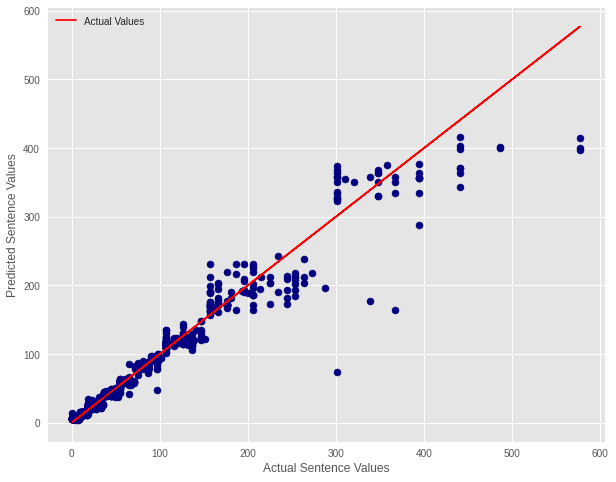

In [ ]:
# Plot predicted vs actual values with test set
plt.figure(figsize = (10, 8))
plt.scatter(np.exp(y2_test), np.exp(y_pred), color = "navy")
plt.plot(np.exp(y2_test), np.exp(y2_test), c = 'red', label = 'Actual Values')
plt.xlabel('Actual Sentence Values')
plt.ylabel('Predicted Sentence Values')
plt.legend()
plt.show()

**Random Forest**

In [ ]:
# Import the model we are using
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000)

# Train the model on training data
rf.fit(X2_train, y2_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=40, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=105, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# Use the forest's predict method on the test data
y_predrf = rf.predict(X2_test)

# Calculate the absolute errors
errors = abs(y_predrf - y2_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Print mean squared error
print('Mean Squared Error: ', mean_squared_error(y2_test, y_predrf))

# Scores
print('Training set score: ',rf.score(X2_train, y2_train), '\n' + 'Test set score: ', rf.score(X2_test, y2_test))

Mean Absolute Error: 0.14
Mean Squared Error:  0.04757918225651996
Training set score:  0.9568982007886591 
Test set score:  0.9484424440321184


In [ ]:
# Cross Validate
cross_val = cross_val_score(rf, X2, y2, cv = 5)
print('\nCross Val for Random Forest:')
print(cross_val)
print('\nCross Validation Mean Score: ')
print(cross_val.mean())


Cross Val for Random Forest:
[0.93781903 0.94171173 0.96083966 0.95102238 0.92638506]

Cross Validation Mean Score: 
0.9435555726385733


Some overfitting is possible being that train set performed 3 percent better than the test set.

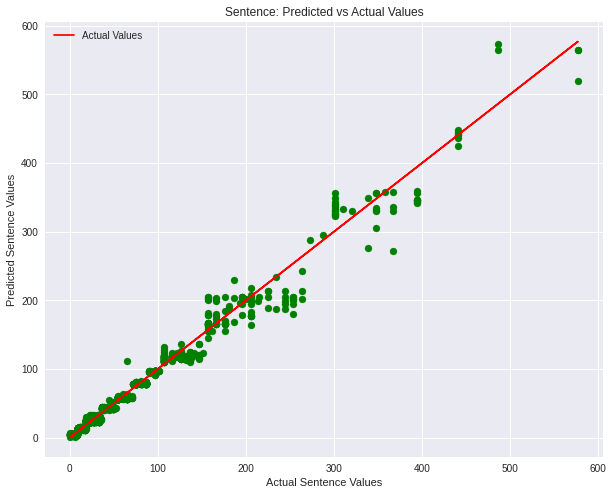

In [ ]:
# Plot prediction vs actual
plt.figure(figsize = (10, 8))
plt.scatter(np.exp(y2_test), np.exp(y_predrf), c = 'g')
plt.plot(np.exp(y2_test), np.exp(y2_test), c = 'red', label = 'Actual Values')
plt.title('Sentence: Predicted vs Actual Values')
plt.xlabel('Actual Sentence Values')
plt.ylabel('Predicted Sentence Values')
plt.legend()
plt.show()

Will create a plot with features of importance

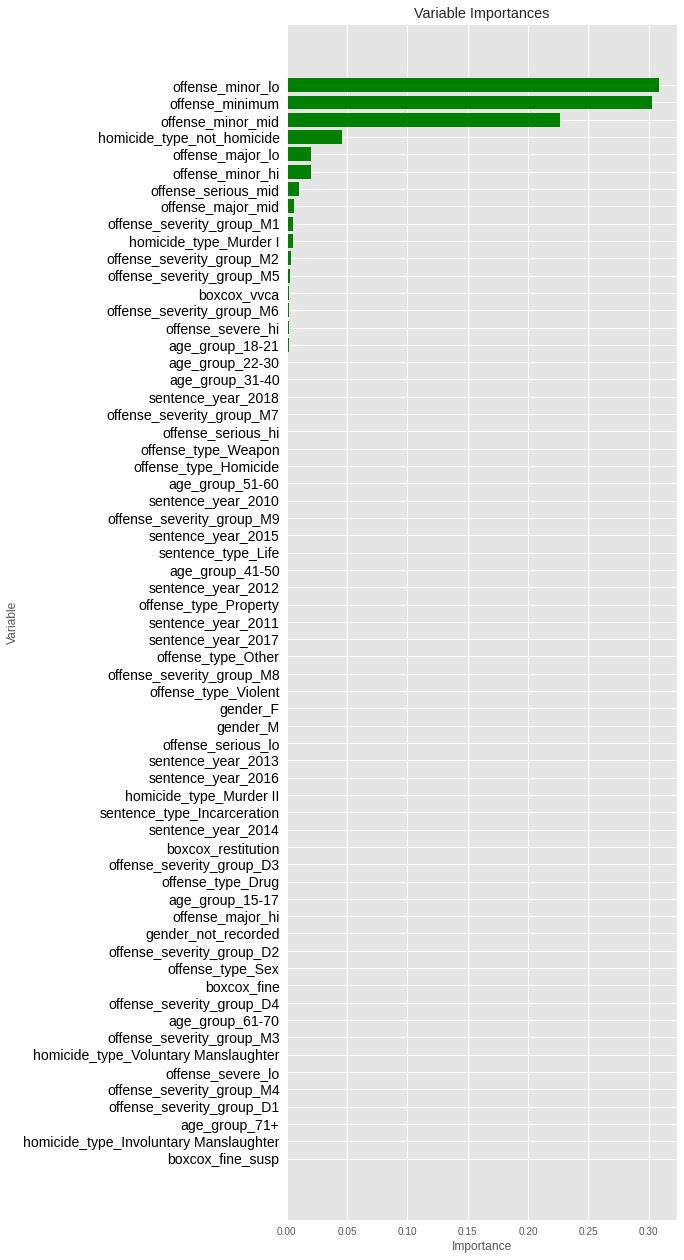

In [ ]:
# Sorted feature importance plot
plt.figure(figsize = (7,22))
features = X2.columns
importances = rf.feature_importances_
feature_list = np.argsort(importances)

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.barh(range(len(feature_list)), importances[feature_list], align = 'center', color = 'g')
# Tick labels for x axis
plt.yticks(range(len(feature_list)), [features[i] for i in feature_list], size = 14, c = 'black')
# Axis labels and title
plt.ylabel('Variable'); plt.xlabel('Importance'); plt.title('Variable Importances')
plt.show()

Will adjust data set for next random forest model with gridsearch by removing features of minimal importance.
* year
* gender
* sentence_type

Tuning with GridSearch

In [ ]:
# Creating new dataframe and removing features of minimal importance
prison_nonlin_rf = prison_nonlin_df.loc[:,~prison_nonlin_df.columns.str.contains('sentence_year_', case = False)] 
prison_nonlin_rf = prison_nonlin_rf.loc[:,~prison_nonlin_rf.columns.str.contains('gender_', case = False)] 
prison_nonlin_rf = prison_nonlin_rf.loc[:,~prison_nonlin_rf.columns.str.contains('sentence_type_', case = False)] 

In [ ]:
# Split data into feature and target
Xrf = prison_nonlin_rf.drop(columns = ['boxcox_sentence'])
yrf = prison_nonlin_rf.boxcox_sentence

# Split data
Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(Xrf, yrf, train_size = 0.80, test_size = 0.20, random_state = 2)

In [ ]:
# Create the regressor 
rfr = RandomForestRegressor(bootstrap=True)

# setting the parameters
param_grid = dict(n_estimators = np.arange(100, 130, 5), min_samples_leaf = np.arange(1, 4, 1), max_depth = np.arange(5, 50, 5), max_features = np.arange(15, 50, 5))

# Run cross validation with cv = 5
grid = GridSearchCV(rfr, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

# Train model with best parameters
grid.fit(Xrf_train, yrf_train)

# Print the best parameters
print(grid.best_params_)

{'max_depth': 10, 'max_features': 40, 'min_samples_leaf': 1, 'n_estimators': 105}


Best Parameters: min_sample_leaf = 1, n_estimators = 105, max_depth = 10, max_features = 40 

WILL APPLY TO RANDOM FOREST MODEL 1

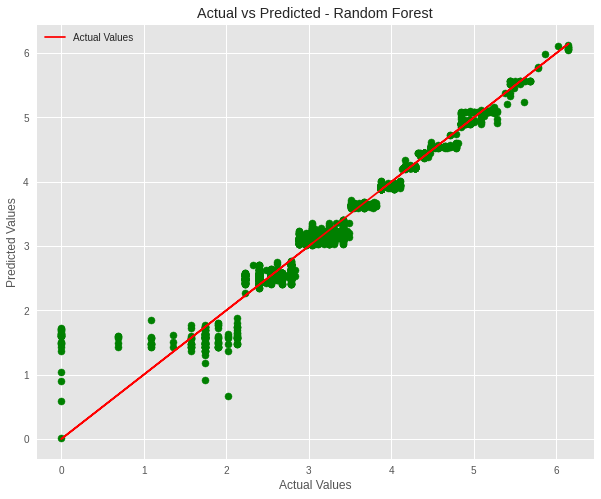

In [ ]:
# Predict with test set
grid_predictions = grid.predict(Xrf_test)

# plot actual values versus predictions
plt.figure(figsize = (10, 8))
plt.scatter(yrf_test, grid_predictions, color = 'green')
plt.plot(yrf_test, yrf_test, c = 'red', label = 'Actual Values')
plt.title('Actual vs Predicted - Random Forest')
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')
plt.legend()
plt.show()

Additional Metrics for Random Forest CV Model

In [ ]:
 from sklearn.metrics import explained_variance_score
 
 # Variance explained with training data
 grid_predictions_train = grid.predict(Xrf_train)
 explained_variance_score(yrf_train, grid_predictions_train)

0.9518673702566403

In [ ]:
# Calculate the absolute errors
errorsCV = abs(grid_predictions - yrf_test)

# Print out the mean absolute error (mae)
print(' Mean Absolute Error:', round(np.mean(errorsCV), 2))

# Print mean squared error
print('Mean Squared Error: ', mean_squared_error(yrf_test, grid_predictions))

# Print variance explained value for test set
from sklearn.metrics import explained_variance_score
print('\n', 'Explained Variance Score: ', explained_variance_score(yrf_test, grid_predictions))

 Mean Absolute Error: 0.13
Mean Squared Error:  0.04649340859185195

 Explained Variance Score:  0.9399402901755971


**Results**

Various linear model regressions were created with techniques focused on regularization. A Support Vector Regressor as well as Random Forest models were also tested and cross validated.

Random forest had a a slightly better explanation of variance on test sets consistently with a lower mean absolute error. However, it does come at a higher cost in time. 

The overall performance of the OLS model is the best rival to Random Forest due to the simplicity. However Random Forest metrics are superior to those corresponding to the other models in the study, making it the model of choice for this project. 

The model’s primary intent was to achieve a high level of certainty in predicting a sentence for someone convicted of a crime in Washington DC. A secondary objective of the study was to investigate whether or not race is a factor in predicting a prison sentence. The primary objective was achieved by all models. One shortcoming found in the selected model as well as in the rest of the models created is that most of the errors in predictions are centered on the sentences of middle to higher lengths. There is also more balanced data required to be succesful in achieving the second objective. The dataset has a distribtuion of race that does not include a balanced number of variables.